In [1]:
!pip install snfpy lifelines umap-learn hdbscan 

In [ ]:
import os
import re
import matplotlib as mpl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap
from tabulate import tabulate
import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances
from snf.compute import snf
from sklearn.manifold import TSNE
from scipy import stats
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import SpectralEmbedding
from sklearn.mixture import GaussianMixture
import hdbscan
from scipy.stats import f_oneway, chi2_contingency
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.manifold import MDS
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import SpectralClustering, KMeans
from scipy.spatial.distance import squareform
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import warnings
warnings.filterwarnings("ignore", message=".*force_all_finite.*")
warnings.filterwarnings("ignore", category=UserWarning, module="umap")


In [3]:
# Load files
files = os.listdir()

def try_read(path):
    try:
        if path.lower().endswith('.csv'):
            return pd.read_csv(path, index_col=0)
        elif path.lower().endswith('.xlsx'):
            return pd.read_excel(path, index_col=0)
        else:
            print(f'Unsupported file type for {path}')
            return None
    except Exception as e:
        print('Could not read', path, '->', e)
        return None

circ = try_read(os.path.join('circRNA.csv'))
mir = try_read(os.path.join('miRNA.csv'))
mrna = try_read(os.path.join('mRNA.csv'))
phospho = try_read(os.path.join('phosphoproteome_gene.csv'))
proteome = try_read(os.path.join('proteome_gene.csv'))
scna = try_read(os.path.join('SCNA_gene.csv'))
clin = try_read(os.path.join('clinical_data.csv'))

print(f'Found {len(clin)} unique patients\n')
print('Check dimension of data:')
print('· circRNA:', circ.shape)
print('· miRNA:',  mir.shape)
print('· mRNA:', mrna.shape)
print('· phosphoproteome:', phospho.shape)
print('· proteome:', proteome.shape)
print('· SCNA:', scna.shape)

Found 140 unique patients

Check dimension of data:
· circRNA: (3979, 137)
· miRNA: (2416, 137)
· mRNA: (28057, 137)
· phosphoproteome: (8004, 137)
· proteome: (11662, 137)
· SCNA: (19906, 137)


In [4]:
datasets = {
    "circRNA": circ,
    "miRNA": mir,
    "mRNA": mrna,
    "phosphoproteome": phospho,
    "proteome": proteome,
    "SCNA": scna,
}

summary_rows = []

for name, df in datasets.items():
    if df is None:
        summary_rows.append([name, "Not loaded", "Not loaded", "Not loaded", "Not loaded"])
        continue

    features = df.shape[0]
    samples = df.shape[1]
    na_count = df.isna().sum().sum()
    na_pct = (na_count / (features * samples)) * 100 if features * samples > 0 else 0

    summary_rows.append([
        name,
        features,
        samples,
        na_count,
        f"{na_pct:.2f}%"
    ])

summary_table = pd.DataFrame(
    summary_rows,
    columns=["Dataset", "Features", "Patients", "NA Count", "NA %"]
)

bold_headers = [f"\033[1m{h}\033[0m" for h in summary_table.columns]

print(
    tabulate(
        summary_table,
        headers=bold_headers,
        tablefmt="github",
        colalign=("left", "right", "right", "right", "right")
    )
)

|    |         Dataset |   Features |   Patients |   NA Count | NA %   |
|----|-----------------|------------|------------|------------|--------|
| 0  |         circRNA |       3979 |        137 |          0 | 0.00%  |
| 1  |           miRNA |       2416 |        137 |     214634 | 64.85% |
| 2  |            mRNA |      28057 |        137 |          0 | 0.00%  |
| 3  | phosphoproteome |       8004 |        137 |     351329 | 32.04% |
| 4  |        proteome |      11662 |        137 |     392380 | 24.56% |
| 5  |            SCNA |      19906 |        137 |       2091 | 0.08%  |


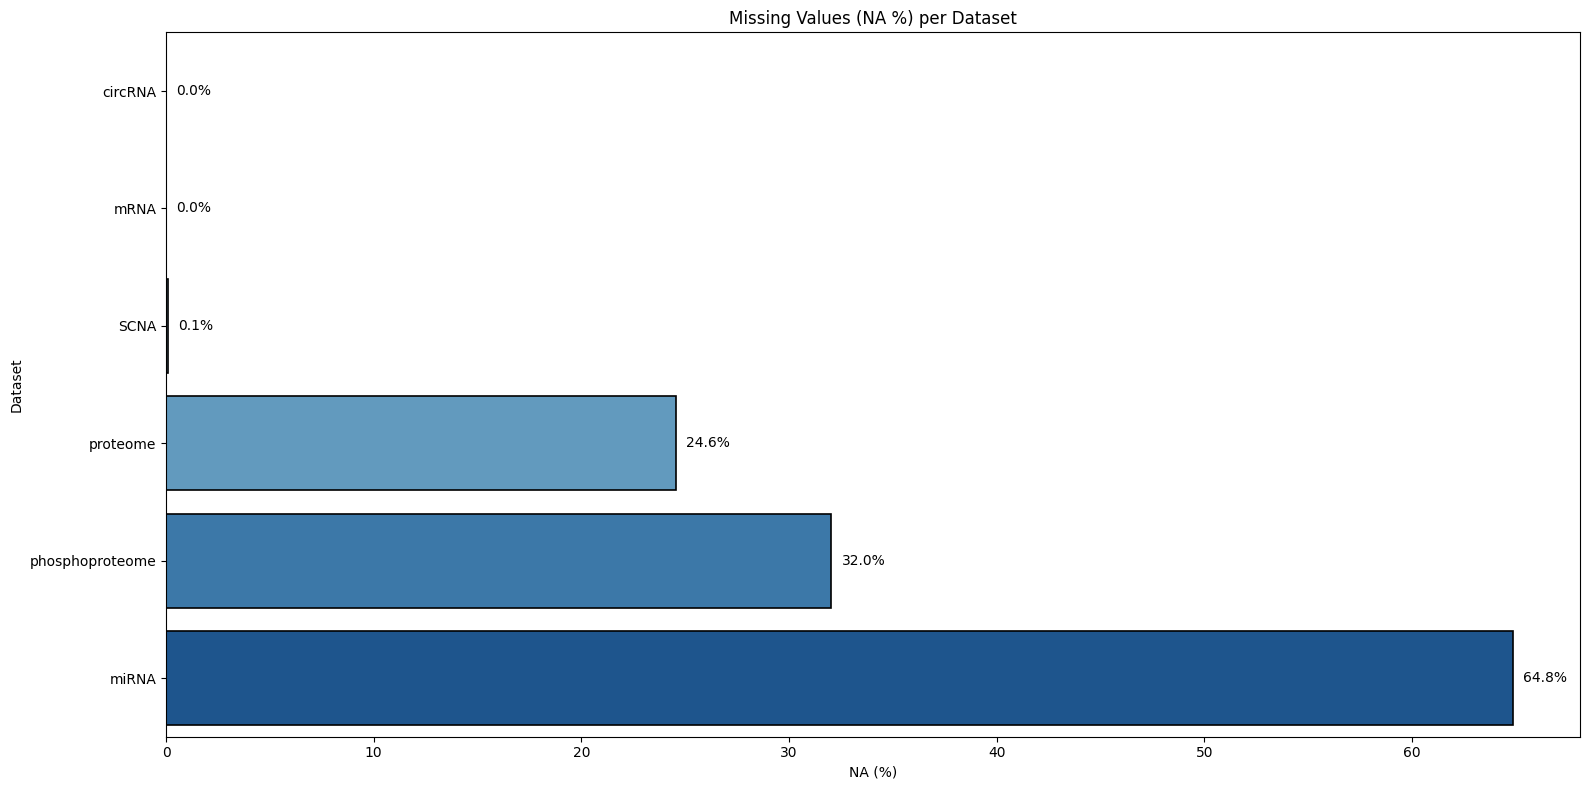

In [55]:
names = summary_table["Dataset"]
na_percent = summary_table["NA %"].str.replace('%','').astype(float)

plot_data = pd.DataFrame({
    'Dataset': names,
    'NA (%)': na_percent
}).sort_values(by='NA (%)', ascending=True)

plt.figure(figsize=(16,8))

# Palette sequenziale percettivamente ottimizzata
palette = sns.color_palette("Blues", n_colors=len(plot_data))

sns.barplot(
    data=plot_data,
    x='NA (%)',
    y='Dataset',
    hue='Dataset',
    palette=palette,
    edgecolor="black",
    linewidth=1.2,
    legend=False
)

for i, value in enumerate(plot_data['NA (%)']):
    plt.text(value + 0.5, i, f"{value:.1f}%", va='center')

plt.xlabel("NA (%)")
plt.ylabel("Dataset")
plt.title("Missing Values (NA %) per Dataset")
plt.tight_layout()
plt.show()

In [6]:
# Data preprocessing and alignment
def preprocess_omics_data(datasets, clinical_data):
    """
    Preprocess omics datasets:
    - Transpose so patients are rows
    - Align patients across all datasets
    - Handle missing values
    - Standardize features
    """
    processed = {}

    # Get common patients across all datasets
    common_patients = set(clinical_data.index)
    for name, df in datasets.items():
        if df is not None:
            common_patients = common_patients.intersection(set(df.columns))

    common_patients = sorted(list(common_patients))
    print(f"Common patients across all datasets: {len(common_patients)}")

    for name, df in datasets.items():
        if df is None:
            continue

        # Transpose: patients as rows, features as columns
        df_t = df[common_patients].T

        # Handle missing values
        df_t = df_t.fillna(df_t.median())

        # Remove features with zero variance
        variance = df_t.var()
        df_t = df_t.loc[:, variance > 0]

        # Standardize (important for distance calculations)
        scaler = StandardScaler()
        df_scaled = pd.DataFrame(
            scaler.fit_transform(df_t),
            index=df_t.index,
            columns=df_t.columns
        )

        processed[name] = df_scaled
        print(f"· {name}: {df_scaled.shape[0]} patients × {df_scaled.shape[1]} features")

    return processed, common_patients

processed_data, common_patients = preprocess_omics_data(datasets, clin)

Common patients across all datasets: 137
· circRNA: 137 patients × 3167 features
· miRNA: 137 patients × 2344 features
· mRNA: 137 patients × 25954 features
· phosphoproteome: 137 patients × 7951 features
· proteome: 137 patients × 11631 features
· SCNA: 137 patients × 19892 features


In [7]:
# Compute similarity matrices for each omics type 
def compute_similarity_matrix(data, metric='euclidean', k=20):
    """
    Compute similarity matrix from data

    Parameters:
    - data: DataFrame with patients as rows
    - metric: distance metric ('euclidean', 'correlation', etc.)
    - k: number of nearest neighbors for kernel

    Returns:
    - similarity matrix (patients × patients)
    """
    n_samples = data.shape[0]

    # Compute pairwise distances
    if metric == 'correlation':
        # Compute correlation between patients (rows)
        corr_matrix = np.corrcoef(data.values, rowvar=True)
        distance_matrix = 1 - corr_matrix
        # Ensure non-negative and handle NaNs
        distance_matrix = np.nan_to_num(distance_matrix, nan=1.0)
        distance_matrix = np.abs(distance_matrix)
    else:
        # Euclidean distance
        distance_matrix = euclidean_distances(data.values)

    # Convert distances to similarities using k-nearest neighbors kernel
    similarity = np.zeros((n_samples, n_samples))

    for i in range(n_samples):
        distances = distance_matrix[i, :]

        idx_sorted = np.argsort(distances)
        idx_neighbors = idx_sorted[1:k+1]  
        sigma = np.mean(distances[idx_neighbors])

        # Apply Gaussian kernel to k nearest neighbors
        if sigma > 0:
            similarity[i, idx_neighbors] = np.exp(-distances[idx_neighbors]**2 / (2 * sigma**2))
        else:
            # If sigma is 0, set similarity to 1 for neighbors
            similarity[i, idx_neighbors] = 1.0

    similarity = (similarity + similarity.T) / 2
    np.fill_diagonal(similarity, 1.0)

    return similarity

similarity_matrices = {}
K_NEIGHBORS = 20 

for name, data in processed_data.items():
    print(f"Computing similarity for {name}...")

    # Use correlation for expression data, euclidean for others
    if name in ["circRNA", "miRNA", "mRNA"]:
        metric = 'correlation'
    else:
        metric = 'euclidean'

    sim_matrix = compute_similarity_matrix(data, metric=metric, k=K_NEIGHBORS)
    similarity_matrices[name] = sim_matrix

    print(f"  {name} similarity matrix: {sim_matrix.shape}")
    print(f"  Mean: {sim_matrix.mean():.3f}, Std: {sim_matrix.std():.3f}")

print("\n✓ All similarity matrices computed successfully!")

Computing similarity for circRNA...
  circRNA similarity matrix: (137, 137)
  Mean: 0.096, Std: 0.209
Computing similarity for miRNA...
  miRNA similarity matrix: (137, 137)
  Mean: 0.096, Std: 0.209
Computing similarity for mRNA...
  mRNA similarity matrix: (137, 137)
  Mean: 0.096, Std: 0.216
Computing similarity for phosphoproteome...
  phosphoproteome similarity matrix: (137, 137)
  Mean: 0.096, Std: 0.179
Computing similarity for proteome...
  proteome similarity matrix: (137, 137)
  Mean: 0.096, Std: 0.178
Computing similarity for SCNA...
  SCNA similarity matrix: (137, 137)
  Mean: 0.096, Std: 0.173

✓ All similarity matrices computed successfully!


# SNF

In [8]:
# Apply SNF to Fuse Networks
def snf_fusion(similarity_matrices, K=20, t=20, alpha=1.0):
    """
    Apply Similarity Network Fusion

    Parameters:
    - similarity_matrices: dict of similarity matrices
    - K: number of nearest neighbors
    - t: number of iterations
    - alpha: hyperparameter (usually 0.5-1.0)

    Returns:
    - fused similarity matrix
    """
    matrices = [mat for mat in similarity_matrices.values()]

    fused_network = snf(matrices, K=K, t=t, alpha=alpha)

    return fused_network

print("Applying SNF to fuse all omics networks...")
# Apply SNF
K = 20  # number of nearest neighbors
T = 20  # number of iterations
ALPHA = 0.8  # hyperparameter

# After SNF fusion, add this:
fused_similarity = snf_fusion(
    similarity_matrices,
    K=K,
    t=T,
    alpha=ALPHA
)

# FIX: Ensure diagonal is exactly 1
np.fill_diagonal(fused_similarity, 1.0)

print(f"\nFused similarity matrix: {fused_similarity.shape}")
print(f"Range: [{fused_similarity.min():.3f}, {fused_similarity.max():.3f}]")

Applying SNF to fuse all omics networks...

Fused similarity matrix: (137, 137)
Range: [0.006, 1.000]


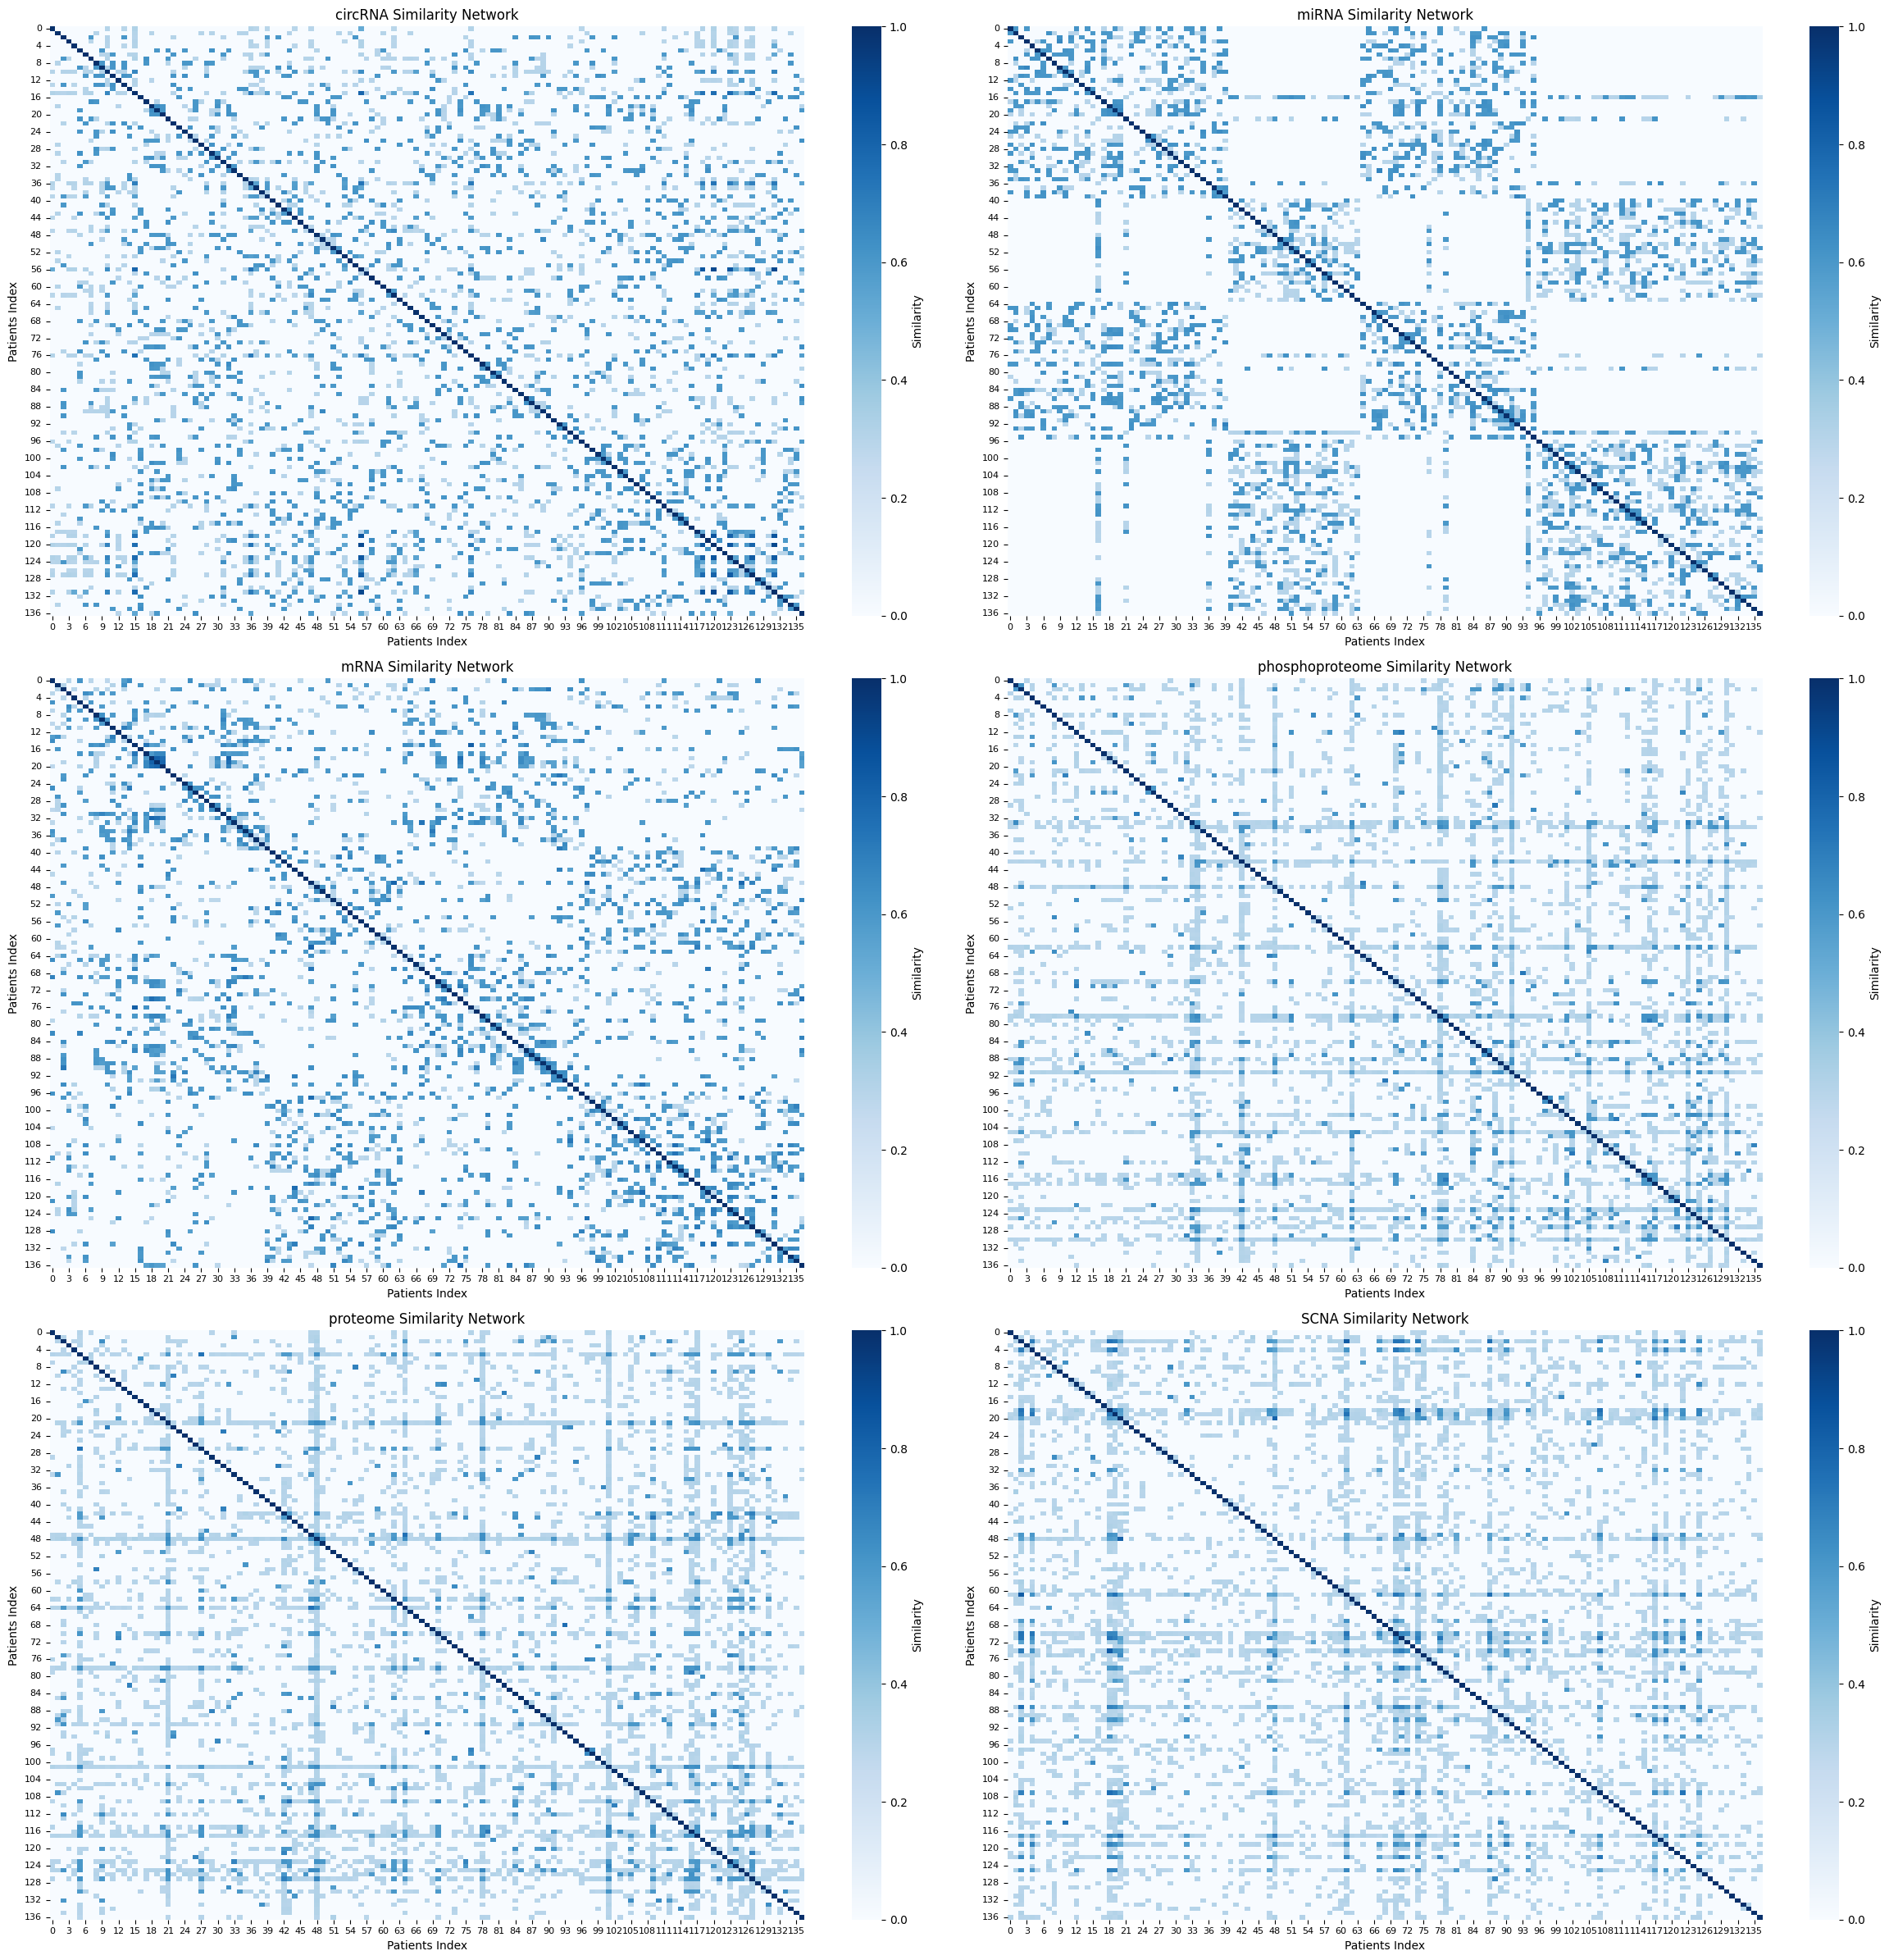

In [61]:
# --- Plot individual similarity matrices ---
n_matrices = len(similarity_matrices)
fig, axes = plt.subplots((n_matrices + 1) // 2, 2, figsize=(24, 24))  # grid for omics
axes = axes.flatten()

for idx, (name, sim_mat) in enumerate(similarity_matrices.items()):
    ax = axes[idx]
    sns.heatmap(sim_mat, cmap='Blues', ax=ax, cbar_kws={'label': 'Similarity'})
    ax.set_title(f'{name} Similarity Network')
    ax.set_xlabel('Patients Index')
    ax.set_ylabel('Patients Index')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va='center', fontsize=8)

plt.tight_layout()
plt.show()

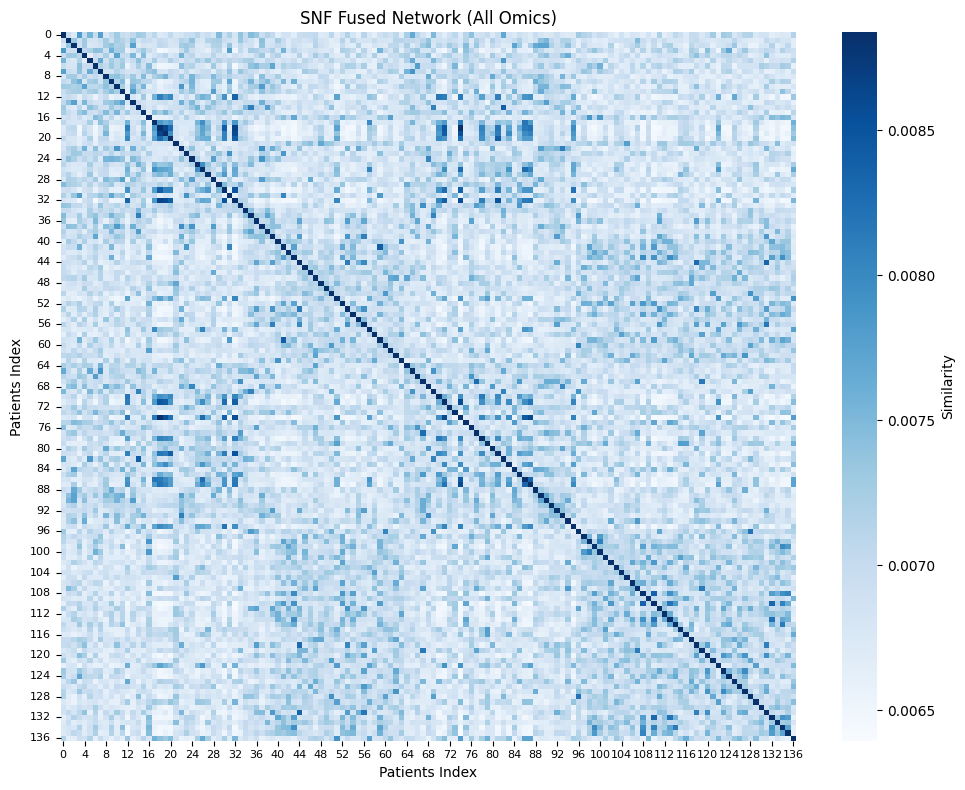

In [60]:
# --- Plot fused similarity matrix separately ---
fused_no_diag = fused_similarity.copy()
np.fill_diagonal(fused_no_diag, np.nan)

vmin = np.nanmin(fused_no_diag)
vmax = np.nanmax(fused_no_diag)

fig_fused, ax_fused = plt.subplots(figsize=(10, 8))

sns.heatmap(
    fused_similarity,
    cmap='Blues',
    ax=ax_fused,
    cbar_kws={'label': 'Similarity'},
    vmin=vmin,
    vmax=vmax
)

ax_fused.set_title('SNF Fused Network (All Omics)')
ax_fused.set_xlabel('Patients Index')
ax_fused.set_ylabel('Patients Index')

ax_fused.set_xticklabels(ax_fused.get_xticklabels(), rotation=0, ha='center', fontsize=8)
ax_fused.set_yticklabels(ax_fused.get_yticklabels(), rotation=0, va='center', fontsize=8)

plt.tight_layout()
plt.show()

In [11]:
# Convert similarity to distance for clustering algorithms that expect distances
fused_distance = 1 - fused_similarity
fused_affinity = fused_similarity.copy()

print("✓ SNF integration complete!")
print(f"· Integrated {len(similarity_matrices)} omics datasets")
print(f"· {len(common_patients)} patients included")
print(f"· Fused similarity matrix ready for clustering")

✓ SNF integration complete!
· Integrated 6 omics datasets
· 137 patients included
· Fused similarity matrix ready for clustering


# Clustering

In [12]:
# Preprocess clinical data
def preprocess_clinical(df):
    """
    Preprocess clinical data with proper encoding strategies
    """
    df = df.copy()

    # Drop useless columns
    df = df.drop(columns=['histology_diagnosis'], errors='ignore')

    # Normalize string columns (strip whitespace)
    obj_cols = df.select_dtypes(include=['object']).columns.tolist()
    for c in obj_cols:
        df[c] = df[c].apply(lambda x: x.strip() if isinstance(x, str) else x)

    # ------------------------
    # Binary encoding
    # ------------------------
    # CORRECTED: Fixed mappings based on actual data
    sex_map = {'male': 0, 'female': 1}
    tumor_necrosis_map = {'not identified': 0, 'present': 1}
    lymph_vascular_map = {'not identified': 0, 'present': 1, 'indetermite': np.nan}  # Note: typo in data
    perineural_map = {'not identified': 0, 'present': 1, 'indetermite': np.nan}
    lost_followup_map = {'no': 0, 'yes': 1}
    vital_status_map = {'living': 0, 'deceased': 1}
    
    if 'sex' in df.columns:
        df['sex'] = df['sex'].astype(str).str.lower().map(sex_map).astype(float)
    if 'tumor_necrosis' in df.columns:
        df['tumor_necrosis'] = df['tumor_necrosis'].astype(str).str.lower().map(tumor_necrosis_map).astype(float)
    if 'lymph_vascular_invasion' in df.columns:
        df['lymph_vascular_invasion'] = df['lymph_vascular_invasion'].astype(str).str.lower().map(lymph_vascular_map).astype(float)
    if 'perineural_invasion' in df.columns:
        df['perineural_invasion'] = df['perineural_invasion'].astype(str).str.lower().map(perineural_map).astype(float)
    if 'is_this_patient_lost_to_follow_up' in df.columns:
        df['is_this_patient_lost_to_follow_up'] = df['is_this_patient_lost_to_follow_up'].astype(str).str.lower().map(lost_followup_map).astype(float)
    if 'vital_status' in df.columns:
        df['vital_status'] = df['vital_status'].astype(str).str.lower().map(vital_status_map).astype(float)

    # ------------------------
    # Ordinal encoding
    # ------------------------
    pN_map = {'pN0': 0, 'pN1': 1, 'pN2': 2, 'pNX': np.nan}
    pT_map = {'pT1a': 1, 'pT1c': 1, 'pT2': 2, 'pT3': 3, 'pT4': 4, 'pTX': np.nan}
    pM_map = {'pM0': 0, 'pM1': 1, 'pMX': np.nan}
    cM_map = {'cM0': 0, 'cM1': 1, 'cMX': np.nan}

    if 'pathologic_staging_regiol_lymph_nodes_pn' in df.columns:
        df['pn_num'] = df['pathologic_staging_regiol_lymph_nodes_pn'].map(pN_map)
    if 'pathologic_staging_primary_tumor_pt' in df.columns:
        df['pt_num'] = df['pathologic_staging_primary_tumor_pt'].map(pT_map)
    if 'pathologic_staging_distant_metastasis_pm' in df.columns:
        df['pm_num'] = df['pathologic_staging_distant_metastasis_pm'].map(pM_map)
    if 'clinical_staging_distant_metastasis_cm' in df.columns:
        df['cm_num'] = df['clinical_staging_distant_metastasis_cm'].map(cM_map)

    # Residual tumor
    if 'residual_tumor' in df.columns:
        df['residual_simple'] = df['residual_tumor'].astype(str).str.extract(r'(R[0-2]|RX)', expand=False)
        res_map = {'R0': 0, 'R1': 1, 'R2': 2, 'RX': np.nan}
        df['residual_num'] = df['residual_simple'].map(res_map)
        df = df.drop(columns=['residual_simple'])

    # Tumor stage - CORRECTED to handle Roman numerals properly
    if 'tumor_stage_pathological' in df.columns:
        stage_map = {
            'stage i': 1,
            'stage ia': 1,
            'stage ib': 1,
            'stage ii': 2,
            'stage iia': 2,
            'stage iib': 2,
            'stage iii': 3,
            'stage iv': 4
        }
        df['tumor_stage_num'] = df['tumor_stage_pathological'].astype(str).str.lower().map(stage_map)

    # Alcohol consumption (ordered) - CORRECTED mapping
    alcohol_map = {
        'lifelong non-drinker': 0,
        'consumed alcohol in the past, but currently a non-drinker': 1,
        'alcohol consumption equal to or less than 2 drinks per day for men and 1 drink or less per day for women': 2,
        'alcohol consumption more than 2 drinks per day for men and more than 1 drink per day for women': 3,
        'alcohol consumption history not available': np.nan  # Changed to NaN instead of 4
    }
    if 'alcohol_consumption' in df.columns:
        df['alcohol_num'] = df['alcohol_consumption'].astype(str).str.lower().map(alcohol_map)

    # Tobacco smoking (ordered) - CORRECTED mapping
    tobacco_map = {
        'lifelong non-smoker: less than 100 cigarettes smoked in lifetime': 0,
        'current reformed smoker, more than 15 years': 1,
        'current reformed smoker within past 15 years': 2,
        'current reformed smoker, years unknown': 3,
        'current smoker: includes daily and non-daily smokers': 4,
        'smoking history not available': np.nan  # Changed to NaN instead of 5
    }
    if 'tobacco_smoking_history' in df.columns:
        df['tobacco_num'] = df['tobacco_smoking_history'].astype(str).str.lower().map(tobacco_map)

    # ------------------------
    # One-hot encoding
    # ------------------------
    # CORRECTED: 'additiol_pathologic_findings' instead of 'additional_pathologic_findings'
    one_hot_cols = ['race', 'participant_country', 'tumor_site', 
                    'cause_of_death', 'additiol_pathologic_findings']
    for col in one_hot_cols:
        if col in df.columns:
            dummies = pd.get_dummies(df[col], prefix=col, dummy_na=False)
            # Convert to float explicitly
            dummies = dummies.astype(float)
            df = pd.concat([df, dummies], axis=1)
            df = df.drop(columns=[col])

    # ------------------------
    # Keep numeric columns only
    # ------------------------
    numeric_df = df.select_dtypes(include=[np.number]).copy()

    return numeric_df
# Apply preprocessing
clinical_processed = preprocess_clinical(clin)
clinical_aligned = clinical_processed.loc[common_patients].copy()
print(f"✓ Clinical data processed: {clinical_aligned.shape}")
print(f" · Features: {clinical_aligned.shape[1]}")
print(f" · Patients: {clinical_aligned.shape[0]}")

✓ Clinical data processed: (137, 67)
 · Features: 67
 · Patients: 137


In [13]:
# Dimensionality reduction for visualization and clustering

# Convert fused similarity to embedding space using multiple methods

# Method 1: Spectral Embedding (from similarity matrix)
n_components = 20  
spectral = SpectralEmbedding(n_components=n_components, affinity='precomputed', random_state=42)
spectral_embedding = spectral.fit_transform(fused_affinity)
print(f"✓ Spectral embedding: {spectral_embedding.shape}")

# Method 2: MDS (Multi-Dimensional Scaling) from distance matrix
mds = MDS(n_components=n_components, dissimilarity='precomputed', random_state=42, n_init=4, max_iter=300)
mds_embedding = mds.fit_transform(fused_distance)
print(f"✓ MDS embedding: {mds_embedding.shape}")

# Method 3: UMAP for 2D visualization (from distance matrix)
umap_2d = UMAP(n_components=2, metric='precomputed', random_state=42, n_neighbors=15, min_dist=0.1)
umap_embedding_2d = umap_2d.fit_transform(fused_distance)
print(f"✓ UMAP 2D embedding: {umap_embedding_2d.shape}")

# Method 4: t-SNE for 2D visualization (from distance matrix)
tsne_2d = TSNE(
    n_components=2,
    metric='precomputed',
    random_state=42,
    perplexity=30,
    init=spectral_embedding[:, :2]  
)
tsne_embedding_2d = tsne_2d.fit_transform(fused_distance)
print(f"✓ t-SNE 2D embedding: {tsne_embedding_2d.shape}")

✓ Spectral embedding: (137, 20)
✓ MDS embedding: (137, 20)
✓ UMAP 2D embedding: (137, 2)
✓ t-SNE 2D embedding: (137, 2)



Evaluating clustering quality for K=2 to K=10...
K=2: Silhouette=0.009, Davies-Bouldin=3.333, Calinski-Harabasz=6.0
K=3: Silhouette=0.020, Davies-Bouldin=4.110, Calinski-Harabasz=5.7
K=4: Silhouette=0.033, Davies-Bouldin=3.718, Calinski-Harabasz=5.6
K=5: Silhouette=0.055, Davies-Bouldin=3.266, Calinski-Harabasz=5.8
K=6: Silhouette=0.071, Davies-Bouldin=2.850, Calinski-Harabasz=6.0
K=7: Silhouette=0.078, Davies-Bouldin=2.744, Calinski-Harabasz=6.0
K=8: Silhouette=0.082, Davies-Bouldin=2.551, Calinski-Harabasz=5.9
K=9: Silhouette=0.084, Davies-Bouldin=2.410, Calinski-Harabasz=5.9
K=10: Silhouette=0.091, Davies-Bouldin=2.200, Calinski-Harabasz=6.2


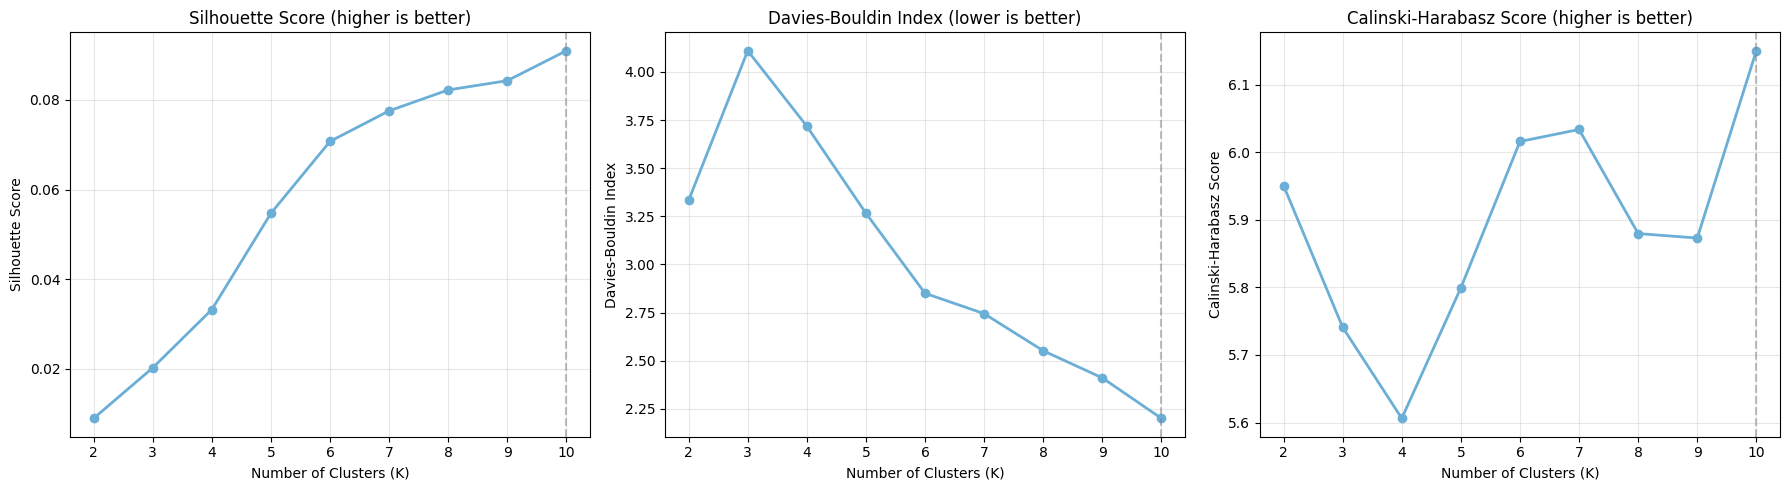


✓ Optimal K suggestions:
  - Silhouette Score: K=10
  - Davies-Bouldin Index: K=10
  - Calinski-Harabasz Score: K=10

Selecting the optimal K based on metrics...
✓ Selected K=10 (as all metrics converged on this value)


In [68]:
# Determine optimal number (K) of clusters
K_range = range(2, 11)  

silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

print("\nEvaluating clustering quality for K=2 to K=10...")

for k in K_range:
    # Use Spectral Clustering on the fused affinity matrix
    spectral_clust = SpectralClustering(
        n_clusters=k, 
        affinity='precomputed', 
        random_state=42,
        assign_labels='kmeans'
    )
    labels = spectral_clust.fit_predict(fused_affinity)
    
    # Calculate metrics
    sil = silhouette_score(spectral_embedding, labels)
    db = davies_bouldin_score(spectral_embedding, labels)
    ch = calinski_harabasz_score(spectral_embedding, labels)
    
    silhouette_scores.append(sil)
    davies_bouldin_scores.append(db)
    calinski_harabasz_scores.append(ch)
    
    print(f"K={k}: Silhouette={sil:.3f}, Davies-Bouldin={db:.3f}, Calinski-Harabasz={ch:.1f}")

# Plot metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(K_range, silhouette_scores, marker='o', color="#6baed6", linewidth=2)
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Score (higher is better)')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(K_range[np.argmax(silhouette_scores)], color='gray', linestyle='--', alpha=0.5)

axes[1].plot(K_range, davies_bouldin_scores, marker='o', color='#6baed6', linewidth=2)
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Davies-Bouldin Index')
axes[1].set_title('Davies-Bouldin Index (lower is better)')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(K_range[np.argmin(davies_bouldin_scores)], color='gray', linestyle='--', alpha=0.5)

axes[2].plot(K_range, calinski_harabasz_scores, marker='o', color='#6baed6', linewidth=2)
axes[2].set_xlabel('Number of Clusters (K)')
axes[2].set_ylabel('Calinski-Harabasz Score')
axes[2].set_title('Calinski-Harabasz Score (higher is better)')
axes[2].grid(True, alpha=0.3)
axes[2].axvline(K_range[np.argmax(calinski_harabasz_scores)], color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Suggest optimal K based on metrics
optimal_k_silhouette = K_range[np.argmax(silhouette_scores)]
optimal_k_db = K_range[np.argmin(davies_bouldin_scores)]
optimal_k_ch = K_range[np.argmax(calinski_harabasz_scores)]

print(f"\n✓ Optimal K suggestions:")
print(f"  - Silhouette Score: K={optimal_k_silhouette}")
print(f"  - Davies-Bouldin Index: K={optimal_k_db}")
print(f"  - Calinski-Harabasz Score: K={optimal_k_ch}")

print("\nSelecting the optimal K based on metrics...")
if optimal_k_silhouette == optimal_k_db == optimal_k_ch:
    OPTIMAL_K = optimal_k_silhouette
    print(f"✓ Selected K={OPTIMAL_K} (as all metrics converged on this value)")
else:
    OPTIMAL_K = optimal_k_silhouette 
    print(f"✓ Selected K={OPTIMAL_K} (based on Silhouette score)")

In [15]:
# Apply multiple clustering algorithms
OPTIMAL_K = optimal_k_silhouette
condensed_dist = squareform(fused_distance)

# ----- 1. Spectral Clustering -----
print("\n1. Spectral Clustering...")
spectral_clustering = SpectralClustering(
    n_clusters=OPTIMAL_K,
    affinity='precomputed',
    random_state=42,
    assign_labels='kmeans'
)
labels_spectral = spectral_clustering.fit_predict(fused_affinity)
print(f"   Cluster distribution: {np.bincount(labels_spectral)}")

# ----- 2. GMM (Gaussian Mixture Model) on Spectral Embedding -----
print("\n2. Gaussian Mixture Model (GMM)...")
gmm = GaussianMixture(
    n_components=OPTIMAL_K,
    covariance_type='full',
    random_state=42,
    n_init=10
)
labels_gmm = gmm.fit_predict(spectral_embedding)
gmm_probs = gmm.predict_proba(spectral_embedding)  # Soft clustering probabilities
print(f"   Cluster distribution: {np.bincount(labels_gmm)}")
print(f"   BIC: {gmm.bic(spectral_embedding):.1f}")
print(f"   AIC: {gmm.aic(spectral_embedding):.1f}")

# ----- 3. HDBSCAN (Hierarchical Density-Based Clustering) -----
print("\n3. HDBSCAN...")
hdbscan_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=5,  # Minimum size of clusters
    min_samples=2,        # Minimum points in neighborhood
    metric='precomputed',
    cluster_selection_epsilon=0.1,
    cluster_selection_method='leaf'  
)
labels_hdbscan = hdbscan_clusterer.fit_predict(fused_distance)
# HDBSCAN assigns -1 to noise points
n_clusters_hdbscan = len(set(labels_hdbscan)) - (1 if -1 in labels_hdbscan else 0)
n_noise = list(labels_hdbscan).count(-1)
print(f"   Number of clusters: {n_clusters_hdbscan}")
print(f"   Noise points: {n_noise}")
if n_clusters_hdbscan > 0:
    print(f"   Cluster distribution: {np.bincount(labels_hdbscan[labels_hdbscan >= 0])}")

# ----- 4. Hierarchical Clustering -----
print("\n4. Hierarchical Clustering...")
linkage_matrix = linkage(condensed_dist, method='ward')
labels_hierarchical = fcluster(linkage_matrix, OPTIMAL_K, criterion='maxclust') - 1
print(f"   Cluster distribution: {np.bincount(labels_hierarchical)}")


1. Spectral Clustering...
   Cluster distribution: [13 14 17 18 11 11 13 14 15 11]

2. Gaussian Mixture Model (GMM)...
   Cluster distribution: [11 17 18 16 13 10 11 14 15 12]
   BIC: -4445.9
   AIC: -11188.1

3. HDBSCAN...
   Number of clusters: 5
   Noise points: 50
   Cluster distribution: [14 33 14 17  9]

4. Hierarchical Clustering...
   Cluster distribution: [12 14 24 24 13  9 10 12  8 11]


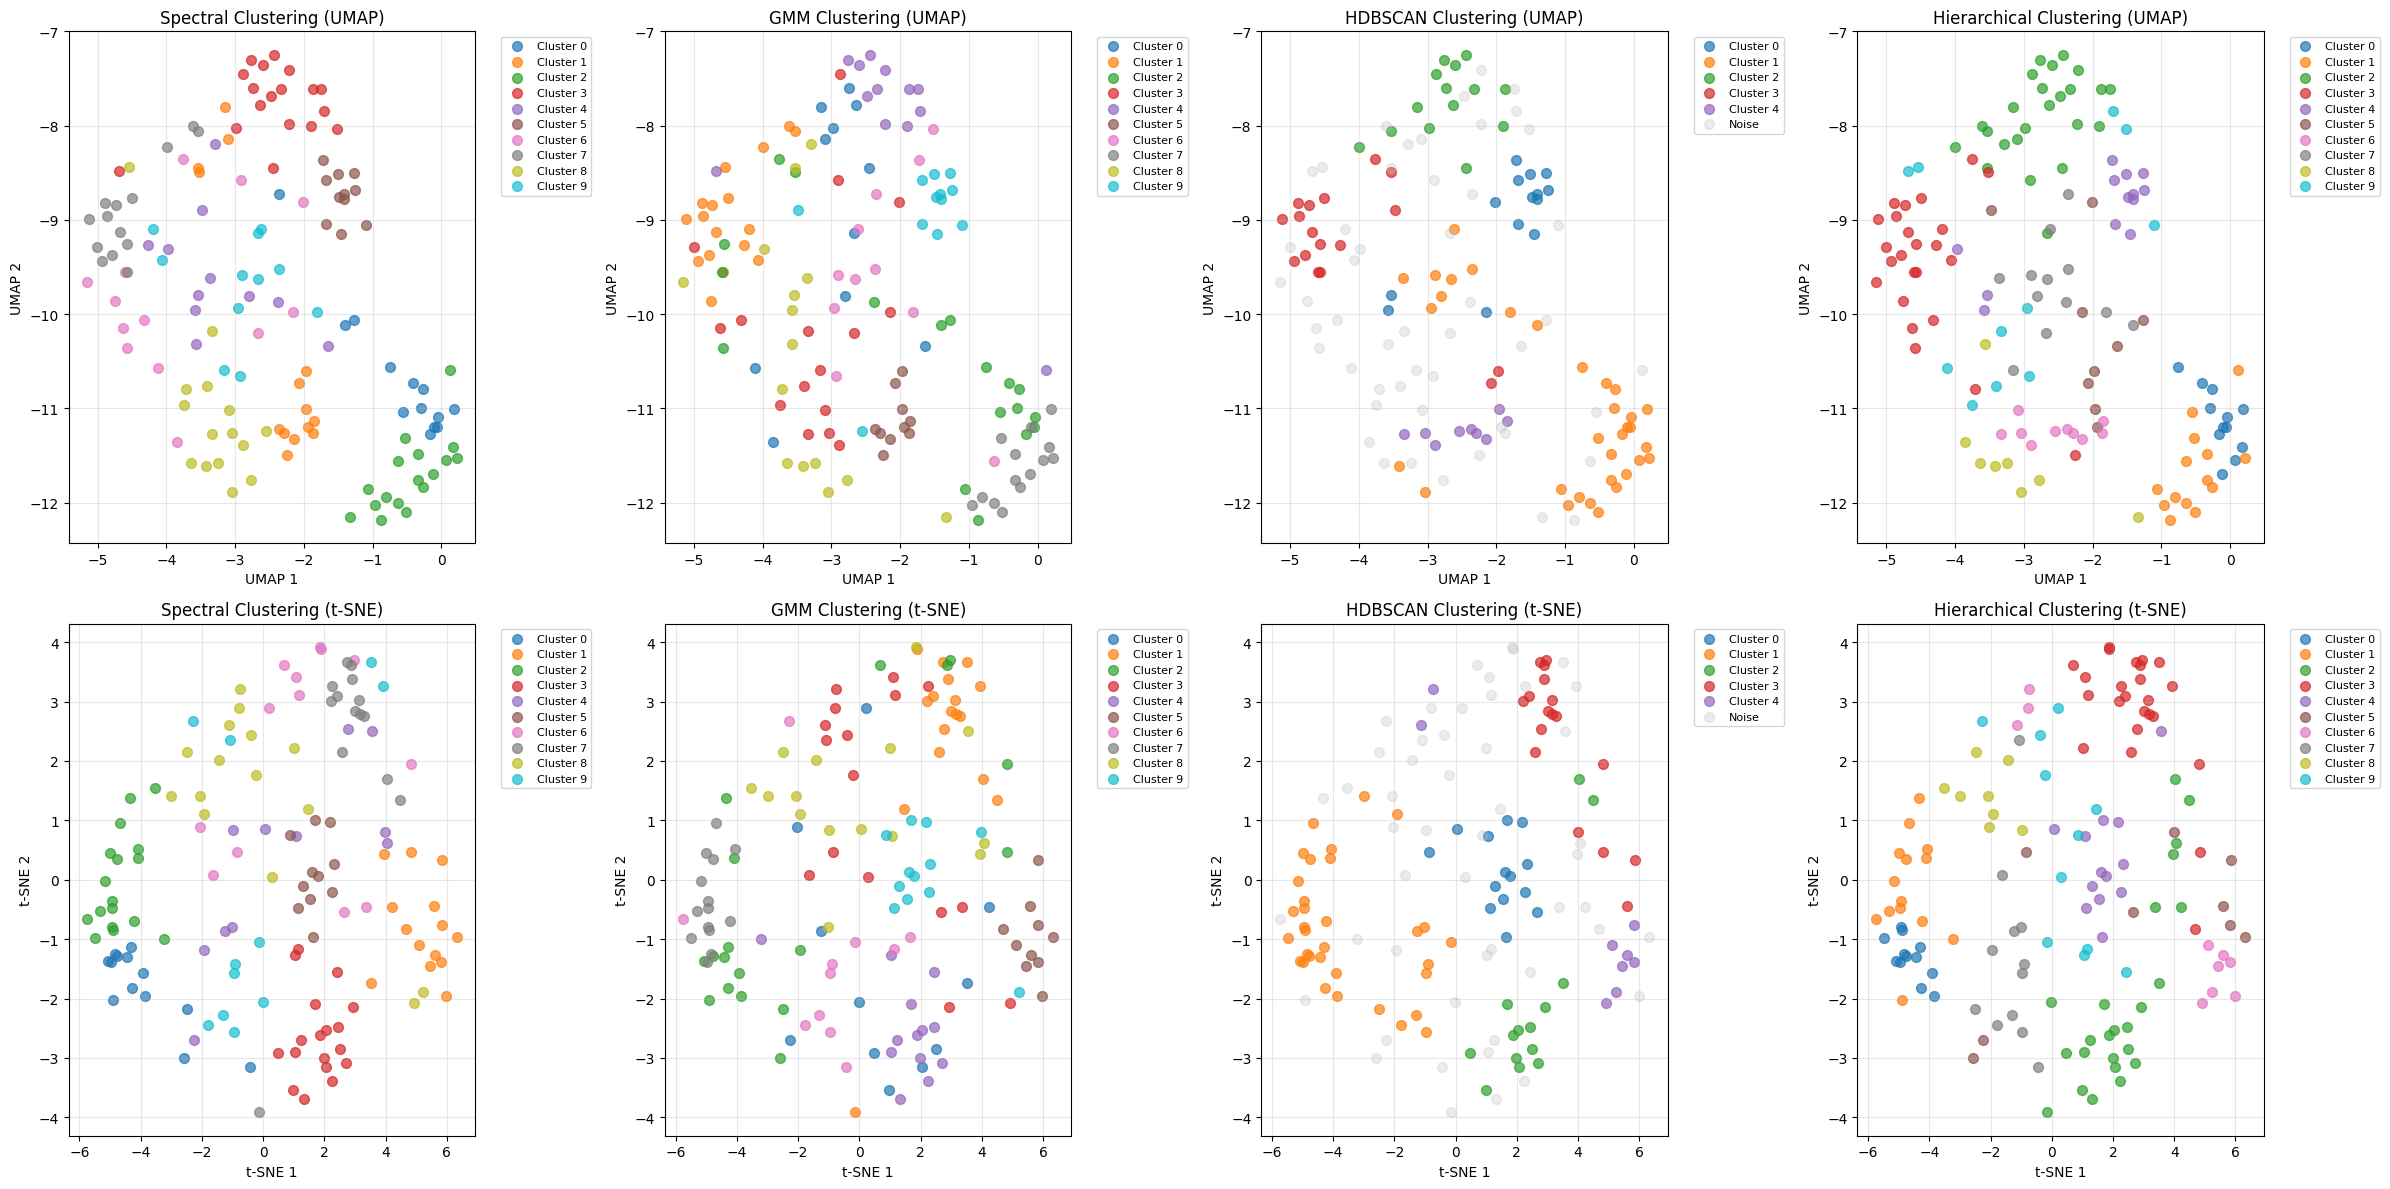

In [16]:
# Visualize clustering results
viz_df = pd.DataFrame({
    'UMAP1': umap_embedding_2d[:, 0],
    'UMAP2': umap_embedding_2d[:, 1],
    'tSNE1': tsne_embedding_2d[:, 0],
    'tSNE2': tsne_embedding_2d[:, 1],
    'Spectral': labels_spectral,
    'GMM': labels_gmm,
    'HDBSCAN': labels_hdbscan,
    'Hierarchical': labels_hierarchical,
    'Patient_ID': common_patients
})
tab20 = mpl.colormaps['tab20'].colors
# Pick 11 maximally separated colors
colors = [
    tab20[0],  tab20[2],  tab20[4],  tab20[6],  tab20[8],
    tab20[10], tab20[12], tab20[14], tab20[16], tab20[18],
    "#BFBFBF"  
]
# Plot all clustering results
fig, axes = plt.subplots(2, 4, figsize=(24, 12))

# Row 1: UMAP projections
for idx, (method, labels) in enumerate([
    ('Spectral', labels_spectral),
    ('GMM', labels_gmm),
    ('HDBSCAN', labels_hdbscan),
    ('Hierarchical', labels_hierarchical)
]):
    ax = axes[0, idx]
    
    if method == 'HDBSCAN':
        # Handle noise points differently
        for label in set(labels):
            if label == -1:
                mask = labels == label
                ax.scatter(umap_embedding_2d[mask, 0], umap_embedding_2d[mask, 1],
                          color='#BFBFBF', alpha=0.3, s=50, label='Noise')
            else:
                mask = labels == label
                ax.scatter(umap_embedding_2d[mask, 0], umap_embedding_2d[mask, 1],
                          color=colors[label % len(colors)], alpha=0.7, s=50, 
                          label=f'Cluster {label}')
    else:
        for label in set(labels):
            mask = labels == label
            ax.scatter(umap_embedding_2d[mask, 0], umap_embedding_2d[mask, 1],
                      color=colors[label % len(colors)], alpha=0.7, s=50,
                      label=f'Cluster {label}')
    
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_title(f'{method} Clustering (UMAP)')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)

# Row 2: t-SNE projections
for idx, (method, labels) in enumerate([
    ('Spectral', labels_spectral),
    ('GMM', labels_gmm),
    ('HDBSCAN', labels_hdbscan),
    ('Hierarchical', labels_hierarchical)
]):
    ax = axes[1, idx]
    
    if method == 'HDBSCAN':
        for label in set(labels):
            if label == -1:
                mask = labels == label
                ax.scatter(tsne_embedding_2d[mask, 0], tsne_embedding_2d[mask, 1],
                          color='#BFBFBF', alpha=0.3, s=50, label='Noise')
            else:
                mask = labels == label
                ax.scatter(tsne_embedding_2d[mask, 0], tsne_embedding_2d[mask, 1],
                          color=colors[label % len(colors)], alpha=0.7, s=50,
                          label=f'Cluster {label}')
    else:
        for label in set(labels):
            mask = labels == label
            ax.scatter(tsne_embedding_2d[mask, 0], tsne_embedding_2d[mask, 1],
                      color=colors[label % len(colors)], alpha=0.7, s=50,
                      label=f'Cluster {label}')
    
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.set_title(f'{method} Clustering (t-SNE)')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Adjusted Rand Index (ARI) - measures agreement between clusterings:
(1.0 = perfect agreement, 0.0 = random, negative = worse than random)

Spectral vs GMM: ARI = 0.428
Spectral vs HDBSCAN: ARI = 0.184
Spectral vs Hierarchical: ARI = 0.376
GMM vs HDBSCAN: ARI = 0.169
GMM vs Hierarchical: ARI = 0.280
HDBSCAN vs Hierarchical: ARI = 0.267


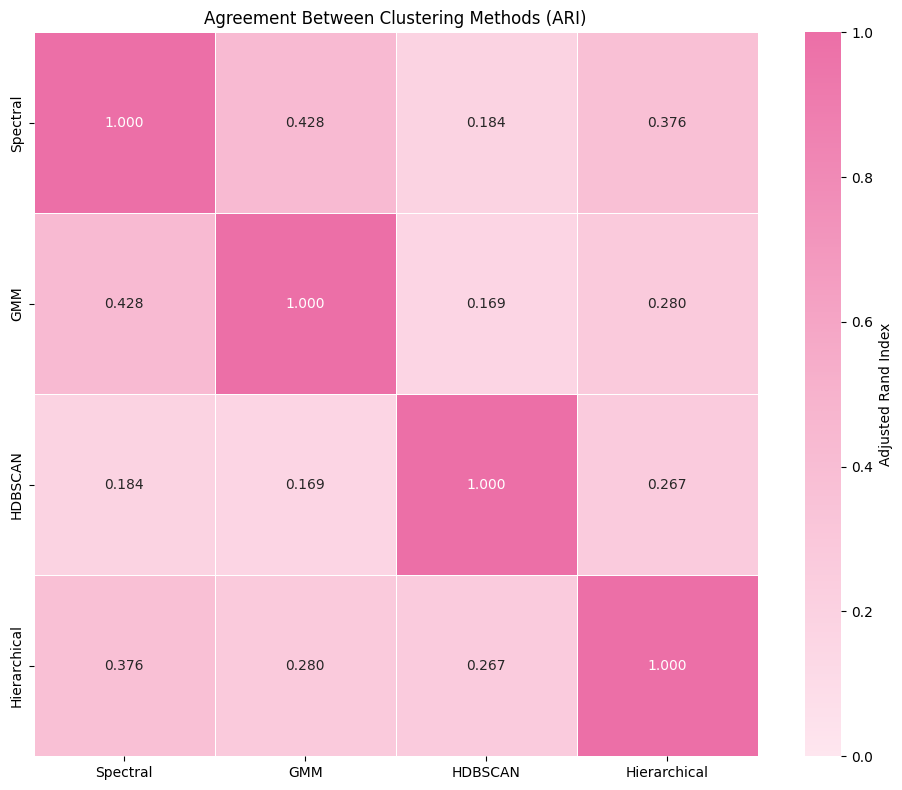

In [103]:
# Compare clustering methods
methods = {
    'Spectral': labels_spectral,
    'GMM': labels_gmm,
    'HDBSCAN': labels_hdbscan,
    'Hierarchical': labels_hierarchical
}

print("\nAdjusted Rand Index (ARI) - measures agreement between clusterings:")
print("(1.0 = perfect agreement, 0.0 = random, negative = worse than random)\n")

ari_matrix = np.zeros((len(methods), len(methods)))
method_names = list(methods.keys())

for i, (name1, labels1) in enumerate(methods.items()):
    for j, (name2, labels2) in enumerate(methods.items()):
        ari = adjusted_rand_score(labels1, labels2)
        ari_matrix[i, j] = ari
        if i < j:
            print(f"{name1} vs {name2}: ARI = {ari:.3f}")

# Plot ARI heatmap
plt.figure(figsize=(10, 8))
cmap = LinearSegmentedColormap.from_list(
    "scientific_pink",
    ["#fee6ef", "#f7b3cd", "#ec6fa7"]
)
sns.heatmap(
    ari_matrix,
    annot=True,
    fmt='.3f',
    cmap=cmap,  
    xticklabels=method_names,
    yticklabels=method_names,
    vmin=0,
    vmax=1,
    cbar_kws={'label': 'Adjusted Rand Index'},
    square=True,
    linewidths=0.5,
    linecolor='white'
)
plt.title('Agreement Between Clustering Methods (ARI)')
plt.tight_layout()
plt.show()

In [18]:
# Select best clustering algorithm
evaluation_results = {}
for method_name, labels in methods.items():
    # Skip if all labels are noise (for HDBSCAN)
    if method_name == 'HDBSCAN' and len(set(labels[labels >= 0])) < 2:
        print(f"\n{method_name}: Insufficient clusters (too many noise points)")
        continue
    
    # For HDBSCAN, exclude noise points from evaluation
    if method_name == 'HDBSCAN':
        valid_mask = labels >= 0
        eval_labels = labels[valid_mask]
        eval_embedding = spectral_embedding[valid_mask]
        
        if len(set(eval_labels)) < 2:
            continue
    else:
        eval_labels = labels
        eval_embedding = spectral_embedding
    
    # Calculate metrics
    sil = silhouette_score(eval_embedding, eval_labels)
    db = davies_bouldin_score(eval_embedding, eval_labels)
    ch = calinski_harabasz_score(eval_embedding, eval_labels)
    
    # Number of clusters
    n_clusters = len(set(eval_labels))
    
    # Cluster size balance (coefficient of variation of cluster sizes)
    cluster_sizes = np.bincount(eval_labels)
    size_cv = np.std(cluster_sizes) / np.mean(cluster_sizes) if np.mean(cluster_sizes) > 0 else np.inf
    
    evaluation_results[method_name] = {
        'silhouette': sil,
        'davies_bouldin': db,
        'calinski_harabasz': ch,
        'n_clusters': n_clusters,
        'size_cv': size_cv,
        'labels': labels
    }
    
    print(f"\n{method_name}:")
    print(f"  Silhouette Score: {sil:.3f}")
    print(f"  Davies-Bouldin Index: {db:.3f}")
    print(f"  Calinski-Harabasz Score: {ch:.1f}")
    print(f"  Number of clusters: {n_clusters}")
    print(f"  Cluster size CV: {size_cv:.3f}")


Spectral:
  Silhouette Score: 0.091
  Davies-Bouldin Index: 2.200
  Calinski-Harabasz Score: 6.2
  Number of clusters: 10
  Cluster size CV: 0.170

GMM:
  Silhouette Score: 0.095
  Davies-Bouldin Index: 2.257
  Calinski-Harabasz Score: 6.1
  Number of clusters: 10
  Cluster size CV: 0.190

HDBSCAN:
  Silhouette Score: 0.125
  Davies-Bouldin Index: 2.338
  Calinski-Harabasz Score: 6.4
  Number of clusters: 5
  Cluster size CV: 0.472

Hierarchical:
  Silhouette Score: 0.077
  Davies-Bouldin Index: 2.294
  Calinski-Harabasz Score: 5.9
  Number of clusters: 10
  Cluster size CV: 0.396


In [19]:
# Normalize metrics to [0, 1] and compute composite score
print("Computing composite scores...")

# Extract metrics for normalization
methods_list = list(evaluation_results.keys())
sil_scores = np.array([evaluation_results[m]['silhouette'] for m in methods_list])
db_scores = np.array([evaluation_results[m]['davies_bouldin'] for m in methods_list])
ch_scores = np.array([evaluation_results[m]['calinski_harabasz'] for m in methods_list])
cv_scores = np.array([evaluation_results[m]['size_cv'] for m in methods_list])

# Normalize (higher is better after normalization)
sil_norm = (sil_scores - sil_scores.min()) / (sil_scores.max() - sil_scores.min() + 1e-10)
db_norm = 1 - (db_scores - db_scores.min()) / (db_scores.max() - db_scores.min() + 1e-10)  # Invert (lower is better)
ch_norm = (ch_scores - ch_scores.min()) / (ch_scores.max() - ch_scores.min() + 1e-10)
cv_norm = 1 - (cv_scores - cv_scores.min()) / (cv_scores.max() - cv_scores.min() + 1e-10)  # Invert (lower is better)

# Compute weighted composite score
# Weights: Silhouette (30%), Davies-Bouldin (25%), Calinski-Harabasz (25%), Balance (20%)
weights = [0.30, 0.25, 0.25, 0.20]
composite_scores = sil_norm * weights[0] + db_norm * weights[1] + ch_norm * weights[2] + cv_norm * weights[3]

# Store composite scores
for i, method_name in enumerate(methods_list):
    evaluation_results[method_name]['composite_score'] = composite_scores[i]
    print(f"{method_name}: Composite Score = {composite_scores[i]:.3f}")

# Select best method
best_method = methods_list[np.argmax(composite_scores)]
best_labels = evaluation_results[best_method]['labels']
print()
print(f"🏆 BEST CLUSTERING METHOD: {best_method}")
print(f"Composite Score: {evaluation_results[best_method]['composite_score']:.3f}")
print(f"Number of clusters: {evaluation_results[best_method]['n_clusters']}")
print(f"Silhouette Score: {evaluation_results[best_method]['silhouette']:.3f}")

Computing composite scores...
Spectral: Composite Score = 0.651
GMM: Composite Score = 0.539
HDBSCAN: Composite Score = 0.550
Hierarchical: Composite Score = 0.131

🏆 BEST CLUSTERING METHOD: Spectral
Composite Score: 0.651
Number of clusters: 10
Silhouette Score: 0.091


# Analyzing clinical feature across clusters

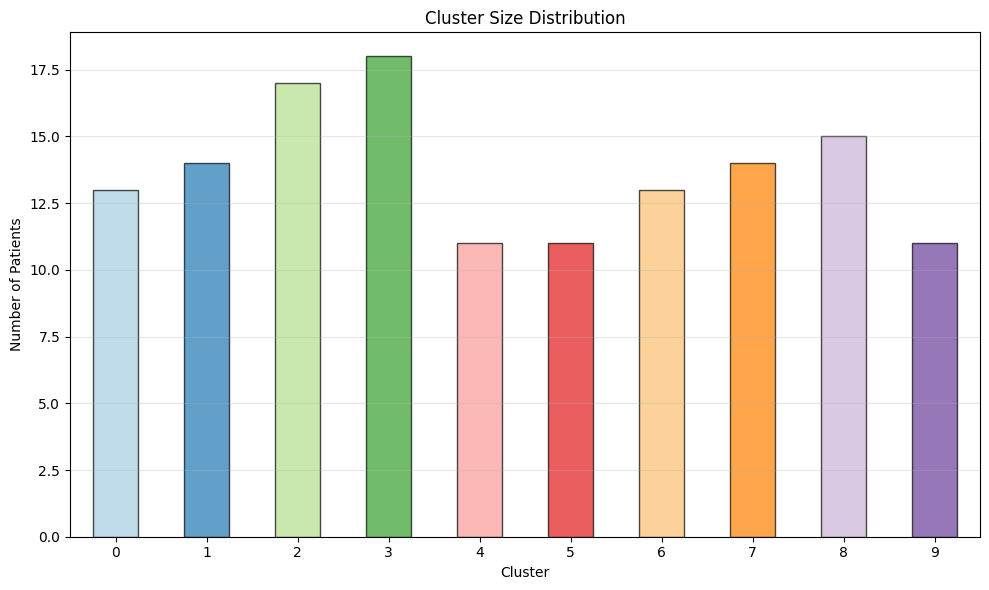

In [79]:
# Clinical feature analysis by cluster
cluster_clinical = clinical_aligned.copy()
cluster_clinical['Cluster'] = best_labels

# Get original clinical data for categorical interpretation
original_clinical = clin.loc[common_patients].copy()
original_clinical['Cluster'] = best_labels

# Remove noise points if using HDBSCAN
if best_method == 'HDBSCAN':
    cluster_clinical = cluster_clinical[cluster_clinical['Cluster'] >= 0]
    original_clinical = original_clinical[original_clinical['Cluster'] >= 0]
    print(f"Note: Removed {(best_labels == -1).sum()} noise points from analysis")

n_clusters = len(set(best_labels[best_labels >= 0]))

# Cluster Size Distribution
cluster_counts = cluster_clinical['Cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    pct = (count / len(cluster_clinical)) * 100
    #print(f"Cluster {cluster_id}: {count} patients ({pct:.1f}%)")

# Visualize cluster sizes
fig, ax = plt.subplots(figsize=(10, 6))
cluster_palette = sns.color_palette("Paired", n_clusters)
cluster_counts.plot(
    kind='bar',
    color=cluster_palette,   
    ax=ax,
    edgecolor='black',
    alpha=0.7
)
ax.set_xlabel('Cluster')
ax.set_ylabel('Number of Patients')
ax.set_title(f'Cluster Size Distribution')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [21]:
print("\nNumber of patients per cluster:")
for cluster_id, count in cluster_counts.items():
    pct = (count / len(cluster_clinical)) * 100
    print(f"  Cluster {cluster_id}: {count} patients ({pct:.1f}%)")



Number of patients per cluster:
  Cluster 0: 13 patients (9.5%)
  Cluster 1: 14 patients (10.2%)
  Cluster 2: 17 patients (12.4%)
  Cluster 3: 18 patients (13.1%)
  Cluster 4: 11 patients (8.0%)
  Cluster 5: 11 patients (8.0%)
  Cluster 6: 13 patients (9.5%)
  Cluster 7: 14 patients (10.2%)
  Cluster 8: 15 patients (10.9%)
  Cluster 9: 11 patients (8.0%)


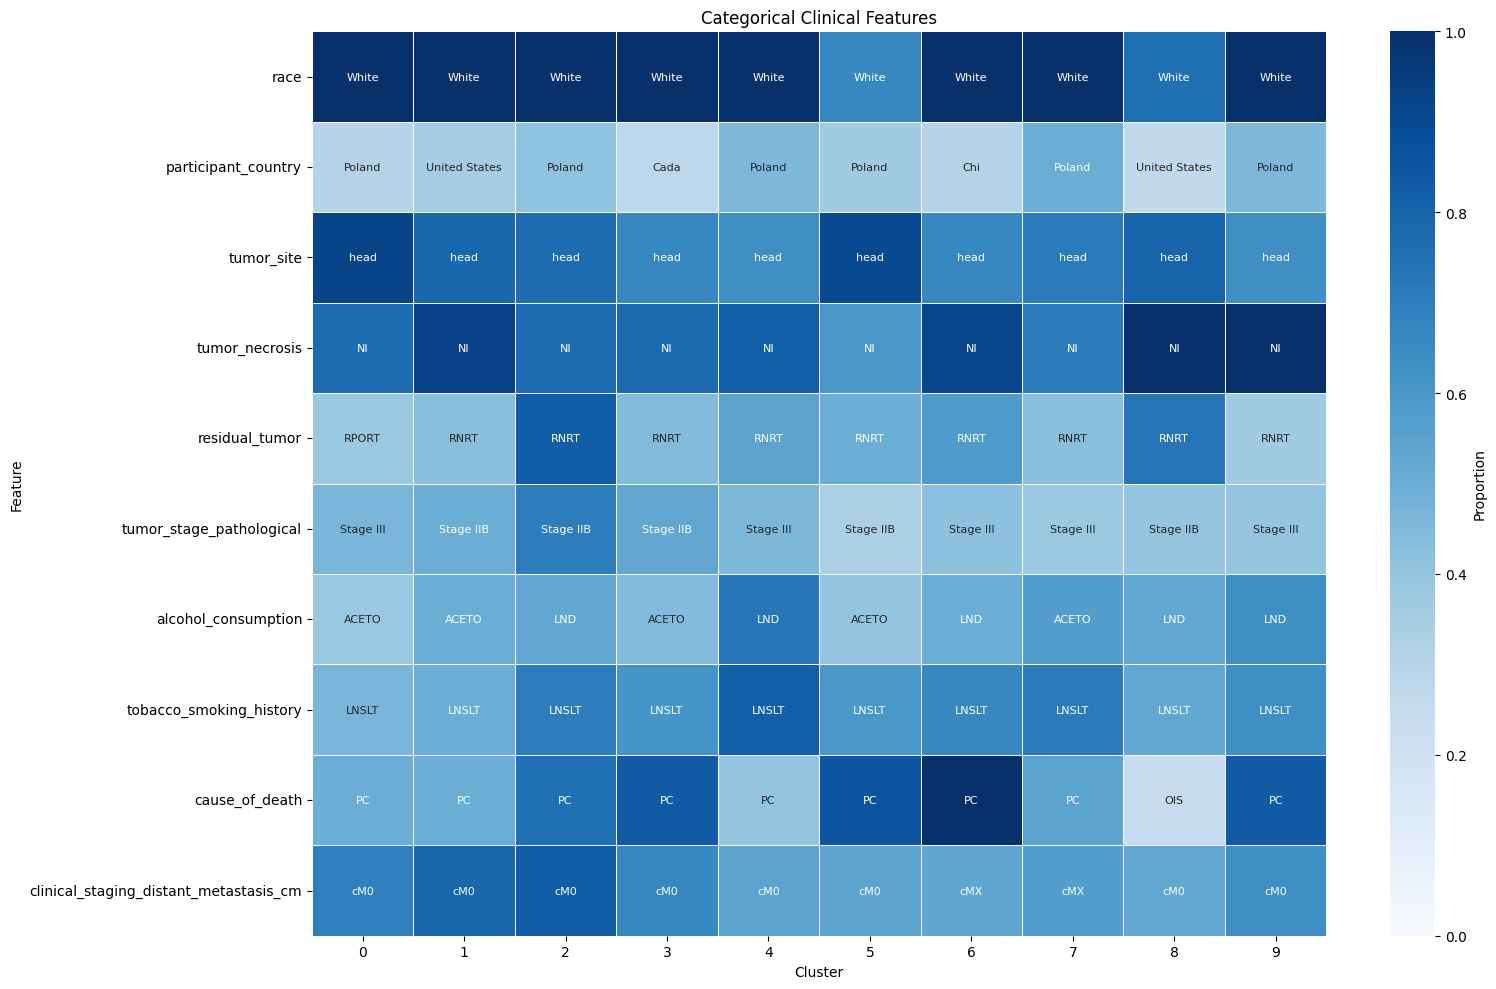


--- Acronym legend ---
NI : Not identified
RPORT : RX:  Presence of residual tumor cannot be assessed
RNRT : R0:  No residual tumor
ACETO : Alcohol consumption equal to or less than 2 drinks per day for men and 1 drink or less per day for women
LND : Lifelong non-drinker
LNSLT : Lifelong non-smoker: Less than 100 cigarettes smoked in lifetime
PC : pancreatic carcinoma
OIS : other : ischemic stroke


In [92]:
analysis_cat = clin.loc[common_patients].copy()
analysis_cat["Cluster"] = best_labels

analysis_num = clinical_aligned.copy()
analysis_num["Cluster"] = best_labels

clusters = sorted(analysis_cat["Cluster"].unique())

CATEGORICAL_VARS = [
    'histology',
    'race',
    'participant_country',
    'tumor_site',
    'tumor_necrosis',
    'residual_tumor',
    'tumor_stage_pathological',
    'alcohol_consumption',
    'tobacco_smoking_history',
    'cause_of_death',
    'clinical_staging_distant_metastasis_cm'
]

NUMERIC_BINARY_VARS = [
    'age_at_diagnosis',
    'bmi',
    'tumor_size',
    'days_to_last_follow_up',
    'sex',
    'vital_status',
    'perineural_invasion',
    'is_this_patient_lost_to_follow_up'
]

CATEGORICAL_VARS = [v for v in CATEGORICAL_VARS if v in analysis_cat.columns]
NUMERIC_BINARY_VARS = [v for v in NUMERIC_BINARY_VARS if v in analysis_num.columns]

MAX_LEN = 18
acronym_legend = {}

CUSTOM_ACRONYMS = {
    "not identified": "NI",
    "notidentified": "NI",
    "not identified ": "NI",
    "not identified": "NI"
}

def make_acronym(text):
    text = re.sub(r'\(.*\)', '', text)
    parts = re.split(r'[\s_\-:]+', text)
    return "".join([p[0].upper() for p in parts if p])[:5]

heatmap_mode = pd.DataFrame(index=CATEGORICAL_VARS, columns=clusters, dtype=object)
heatmap_prop = pd.DataFrame(index=CATEGORICAL_VARS, columns=clusters, dtype=float)

for var in CATEGORICAL_VARS:
    for cl in clusters:
        data = analysis_cat.loc[analysis_cat["Cluster"] == cl, var].dropna()
        if data.empty:
            heatmap_mode.loc[var, cl] = "N/A"
            heatmap_prop.loc[var, cl] = np.nan
            continue
        mode_val = data.mode().iloc[0]
        proportion = (data == mode_val).mean()
        display_val = str(mode_val).strip()
        key = display_val.lower()
        if key in CUSTOM_ACRONYMS:
            acronym = CUSTOM_ACRONYMS[key]
            acronym_legend[acronym] = display_val
            display_val = acronym
        elif len(display_val) > MAX_LEN:
            acronym = make_acronym(display_val)
            original = acronym
            count = 1
            while acronym in acronym_legend and acronym_legend[acronym] != display_val:
                acronym = f"{original}{count}"
                count += 1
            acronym_legend[acronym] = display_val
            display_val = acronym
        heatmap_mode.loc[var, cl] = display_val
        heatmap_prop.loc[var, cl] = proportion

plt.figure(figsize=(16, max(10, len(CATEGORICAL_VARS) * 0.55)))
sns.heatmap(
    heatmap_prop.astype(float),
    annot=heatmap_mode,
    fmt='s',
    cmap='Blues',
    vmin=0,
    vmax=1,
    linewidths=0.5,
    cbar_kws={'label': 'Proportion'},
    annot_kws={"size": 8}
)
plt.title("Categorical Clinical Features")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

if acronym_legend:
    print("\n--- Acronym legend ---")
    for acr, full in acronym_legend.items():
        print(f"{acr} : {full}")

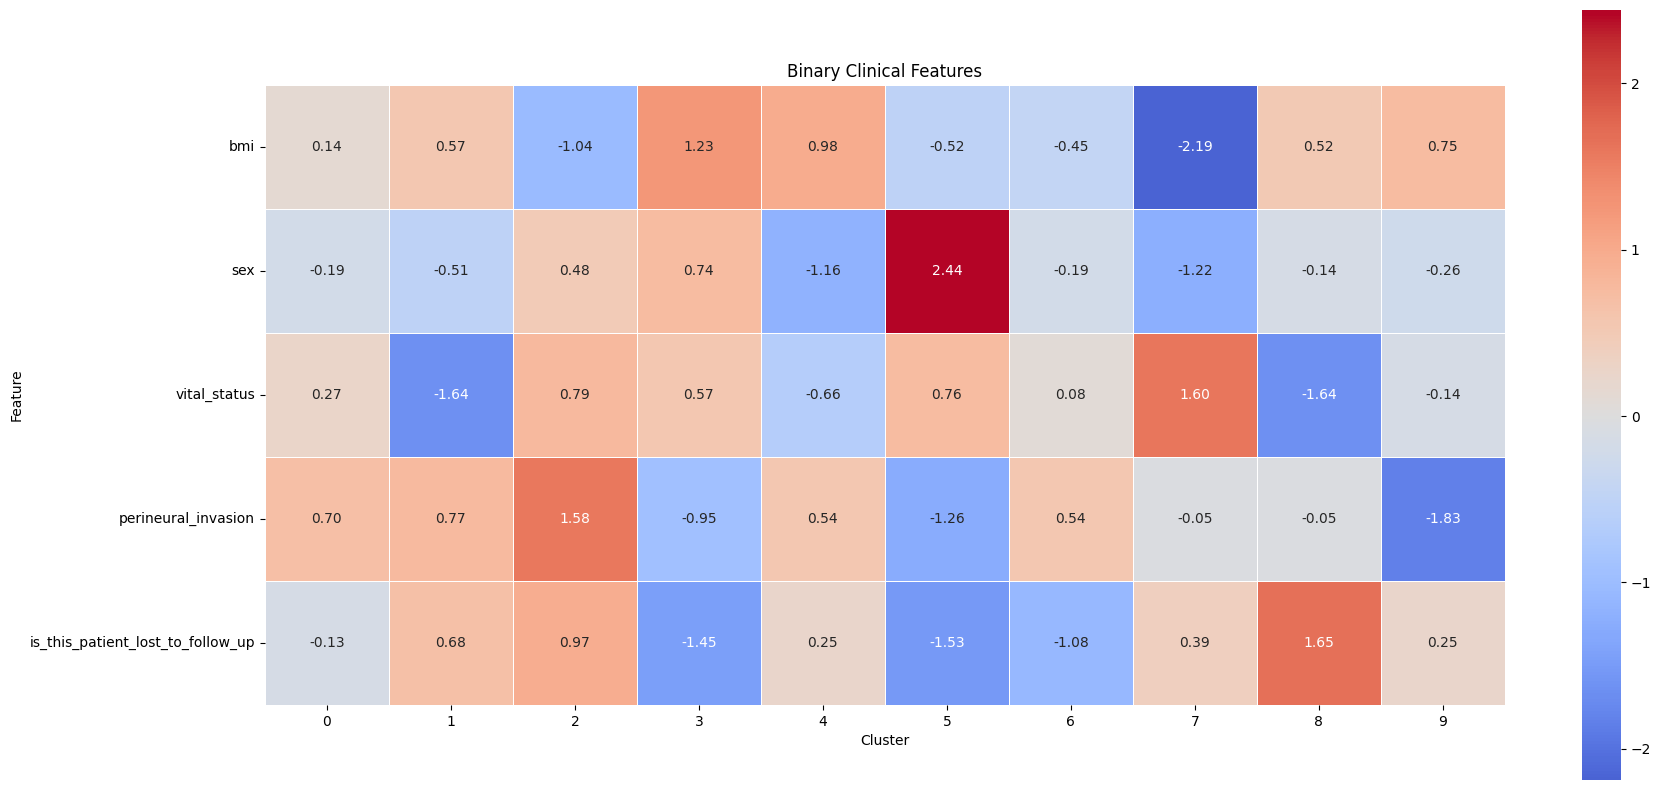

In [112]:
cluster_means = analysis_num.groupby("Cluster")[NUMERIC_BINARY_VARS].mean()
scaler = StandardScaler()
z_scaled = scaler.fit_transform(cluster_means)
z_scaled_df = pd.DataFrame(z_scaled, index=cluster_means.index, columns=cluster_means.columns)

n_rows, n_cols = z_scaled_df.T.shape
fig_height = max(10, len(NUMERIC_BINARY_VARS)*0.55)
cell_height = fig_height / n_rows
fig_width = cell_height * n_cols

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
sns.heatmap(
    z_scaled_df.T,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidth=0.5,
    ax=ax
)
ax.set_aspect("equal")
plt.title("Binary Clinical Features")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.xticks(rotation=0)
plt.show()


In [24]:
# Statistical testing between clusters

# Continuous variables: One-way ANOVA
continuous_vars = ['age_at_initial_pathologic_diagnosis', 'bmi', 'tumor_stage_num', 
                   'pn_num', 'pt_num', 'residual_num', 'alcohol_num', 'tobacco_num']
continuous_vars = [v for v in continuous_vars if v in cluster_clinical.columns]

print("\nOne-way ANOVA (continuous/ordinal variables):")
for var in continuous_vars:
    groups = [
        cluster_clinical[cluster_clinical['Cluster'] == c][var].dropna().values
        for c in sorted(cluster_clinical['Cluster'].unique())
    ]
    
    # Skip if any group is empty
    if not all(len(g) > 0 for g in groups):
        print(f"  {var}: skipped (insufficient data in one or more clusters)")
        continue
    
    # Skip if no variance across all groups
    all_values = np.concatenate(groups)
    if np.all(all_values == all_values[0]):
        print(f"  {var}: skipped (no variability across clusters)")
        continue
    
    # Run ANOVA
    stat, p_value = f_oneway(*groups)
    sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    print(f"  {var}: F={stat:.2f}, p={p_value:.4f} {sig}")


# Binary variables: Chi-square test
binary_vars = ['sex', 'vital_status']
binary_vars = [v for v in binary_vars if v in cluster_clinical.columns]

if binary_vars:
    print("\nChi-Square Test (binary variables):")

    for var in binary_vars:
        contingency_table = pd.crosstab(cluster_clinical['Cluster'], cluster_clinical[var].fillna(-1))
        
        if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
            chi2, p_value, dof, expected = chi2_contingency(contingency_table)
            sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
            print(f"  {var}: χ²={chi2:.2f}, p={p_value:.4f} {sig}")


One-way ANOVA (continuous/ordinal variables):
  bmi: F=1.05, p=0.4010 ns
  tumor_stage_num: F=1.91, p=0.0562 ns
  pn_num: F=1.07, p=0.3875 ns
  pt_num: F=1.69, p=0.0982 ns
  residual_num: F=1.40, p=0.1971 ns
  alcohol_num: F=0.73, p=0.6848 ns
  tobacco_num: F=0.57, p=0.8184 ns

Chi-Square Test (binary variables):
  sex: χ²=4.94, p=0.8398 ns
  vital_status: χ²=23.19, p=0.1836 ns


<Figure size 800x600 with 0 Axes>

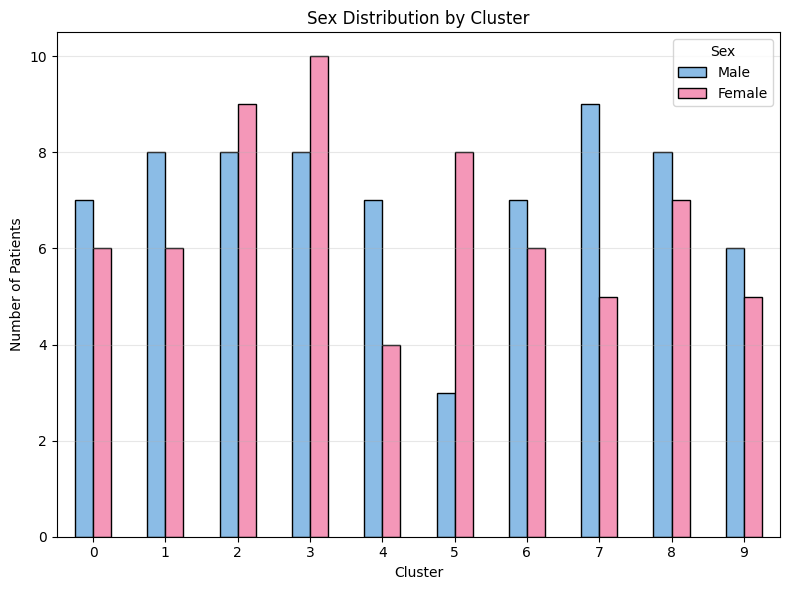

In [113]:
# --- Sex distribution barplot by cluster (counts, custom colors) ---
plt.figure(figsize=(8, 6))
sex_counts = pd.crosstab(cluster_clinical['Cluster'], cluster_clinical['sex'])
sex_counts = sex_counts.rename(columns={0: 'Male', 1: 'Female'})
ax = sex_counts.plot(
    kind='bar',
    stacked=False,
    color={'Female': '#f497b8', 'Male': '#8bbce6'},
    edgecolor='black',
    figsize=(8, 6)
)
plt.xticks(rotation=0)
plt.legend(title="Sex")
plt.xlabel('Cluster')
plt.ylabel('Number of Patients')
plt.title('Sex Distribution by Cluster')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

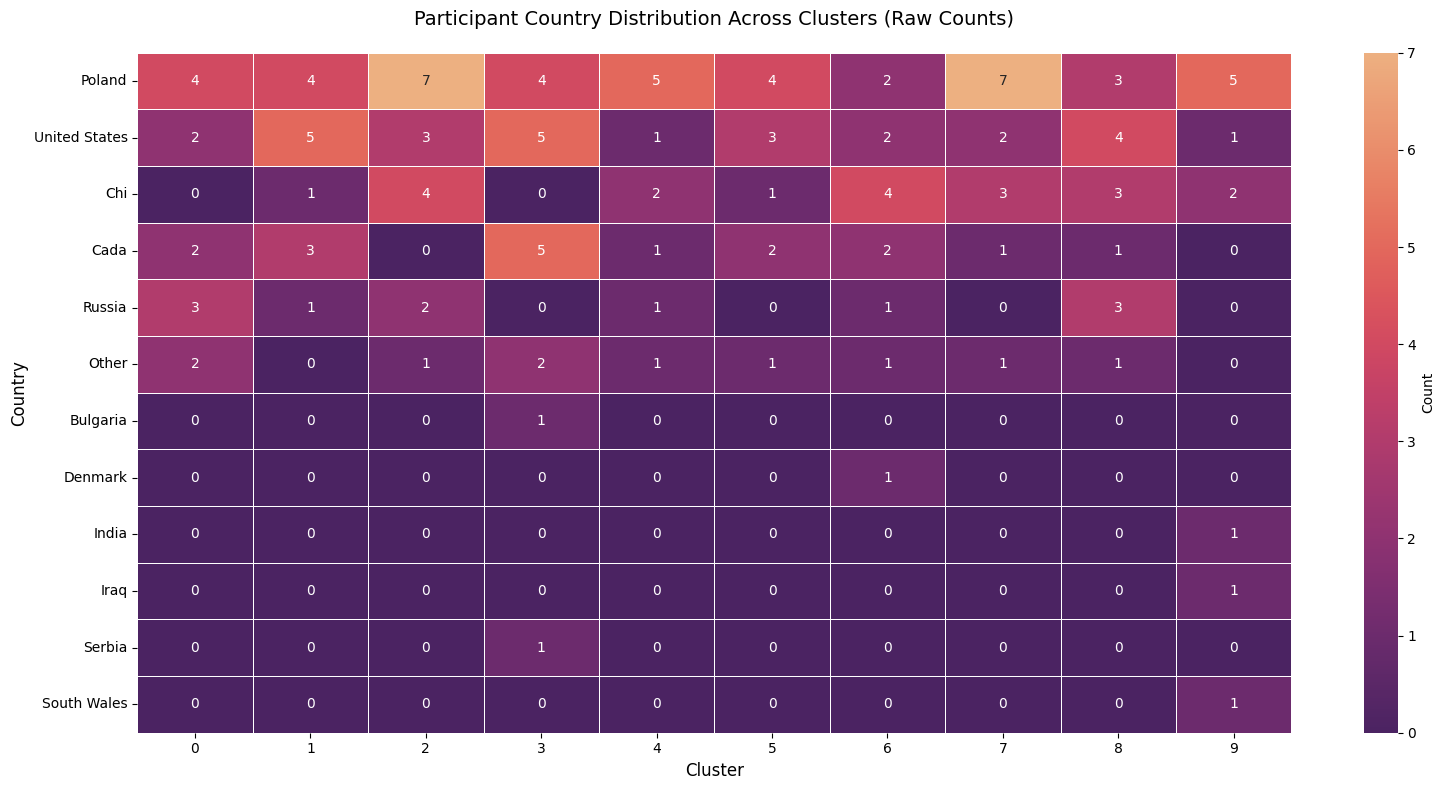

In [ ]:
# --- Participant Country × Cluster ---
country_cluster_crosstab = pd.crosstab(
    original_clinical['participant_country'], 
    original_clinical['Cluster']
)

country_cluster_crosstab = country_cluster_crosstab.loc[
    country_cluster_crosstab.sum(axis=1).sort_values(ascending=False).index
]

plt.figure(figsize=(16, max(8, len(country_cluster_crosstab) * 0.55)))
sns.heatmap(
    country_cluster_crosstab, 
    annot=True, 
    fmt='d',
    cmap='flare_r',
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Count'}
)

plt.title('Participant Country Distribution Across Clusters', fontsize=14, pad=20)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.tick_params(axis='x', rotation=0)
plt.tick_params(axis='y', rotation=0)
plt.tight_layout()
plt.show()

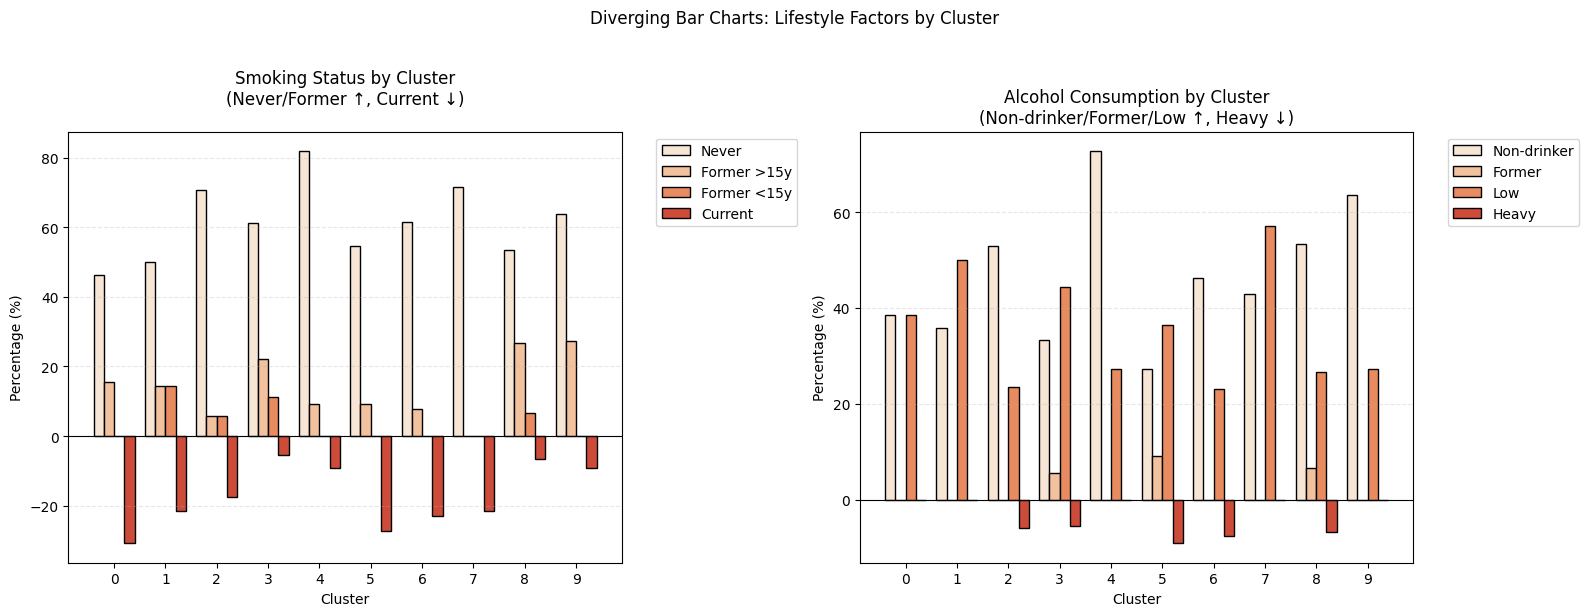

In [130]:
# --- Smoke / Alcohol distribution barplot by cluster (counts, custom colors) ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ====================== Smoking ======================
smoking_data = []
for cluster in sorted(cluster_clinical['Cluster'].unique()):
    data = cluster_clinical[cluster_clinical['Cluster'] == cluster]
    total = len(data)

    smoking_data.append({
        'Cluster': cluster,
        'Never': (data['tobacco_num'] == 0).mean() * 100,
        'Former >15y': (data['tobacco_num'] == 1).mean() * 100,
        'Former <15y': (data['tobacco_num'] == 2).mean() * 100,
        'Current': -(data['tobacco_num'] == 4).mean() * 100  # ↓
    })

smoking_df = pd.DataFrame(smoking_data)
x = np.arange(len(smoking_df))
width = 0.2

axes[0].bar(x - width, smoking_df['Never'], width, 
            label='Never', color='#f7e6d5', edgecolor='black')
axes[0].bar(x, smoking_df['Former >15y'], width,
            label='Former >15y', color='#f2c29f', edgecolor='black')
axes[0].bar(x + width, smoking_df['Former <15y'], width,
            label='Former <15y', color='#e88b61', edgecolor='black')
axes[0].bar(x + 2*width, smoking_df['Current'], width,
            label='Current', color='#cc4c39', edgecolor='black')

axes[0].axhline(0, color='black', linewidth=0.8)
axes[0].set_title('Smoking Status by Cluster\n(Never/Former ↑, Current ↓)', pad=20)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_xticks(x + width/2)
axes[0].set_xticklabels(smoking_df['Cluster'])
axes[0].legend(bbox_to_anchor=(1.05, 1))
axes[0].grid(axis='y', alpha=0.3, linestyle='--')


# ====================== Alcohol ======================
alcohol_data = []
for cluster in sorted(cluster_clinical['Cluster'].unique()):
    data = cluster_clinical[cluster_clinical['Cluster'] == cluster]

    alcohol_data.append({
        'Cluster': cluster,
        'Non-drinker': (data['alcohol_num'] == 0).mean()*100,
        'Former': (data['alcohol_num'] == 1).mean()*100,
        'Low': (data['alcohol_num'] == 2).mean()*100,
        'Heavy': -(data['alcohol_num'] == 3).mean()*100   # ↓ heavy only
    })

alcohol_df = pd.DataFrame(alcohol_data)
x = np.arange(len(alcohol_df))

axes[1].bar(x - width, alcohol_df['Non-drinker'], width,
            label='Non-drinker', color='#f7e6d5', edgecolor='black')
axes[1].bar(x, alcohol_df['Former'], width,
            label='Former', color='#f2c29f', edgecolor='black')
axes[1].bar(x + width, alcohol_df['Low'], width,
            label='Low', color="#e88b61", edgecolor='black')
axes[1].bar(x + 2*width, alcohol_df['Heavy'], width,
            label='Heavy', color='#cc4c39', edgecolor='black')

axes[1].axhline(0, color='black', linewidth=0.8)
axes[1].set_title('Alcohol Consumption by Cluster\n(Non-drinker/Former/Low ↑, Heavy ↓)')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_xticks(x + width/2)
axes[1].set_xticklabels(alcohol_df['Cluster'])
axes[1].legend(bbox_to_anchor=(1.05, 1))
axes[1].grid(axis='y', alpha=0.3, linestyle='--')


plt.suptitle('Diverging Bar Charts: Lifestyle Factors by Cluster', y=1.02)
plt.tight_layout()
plt.show()

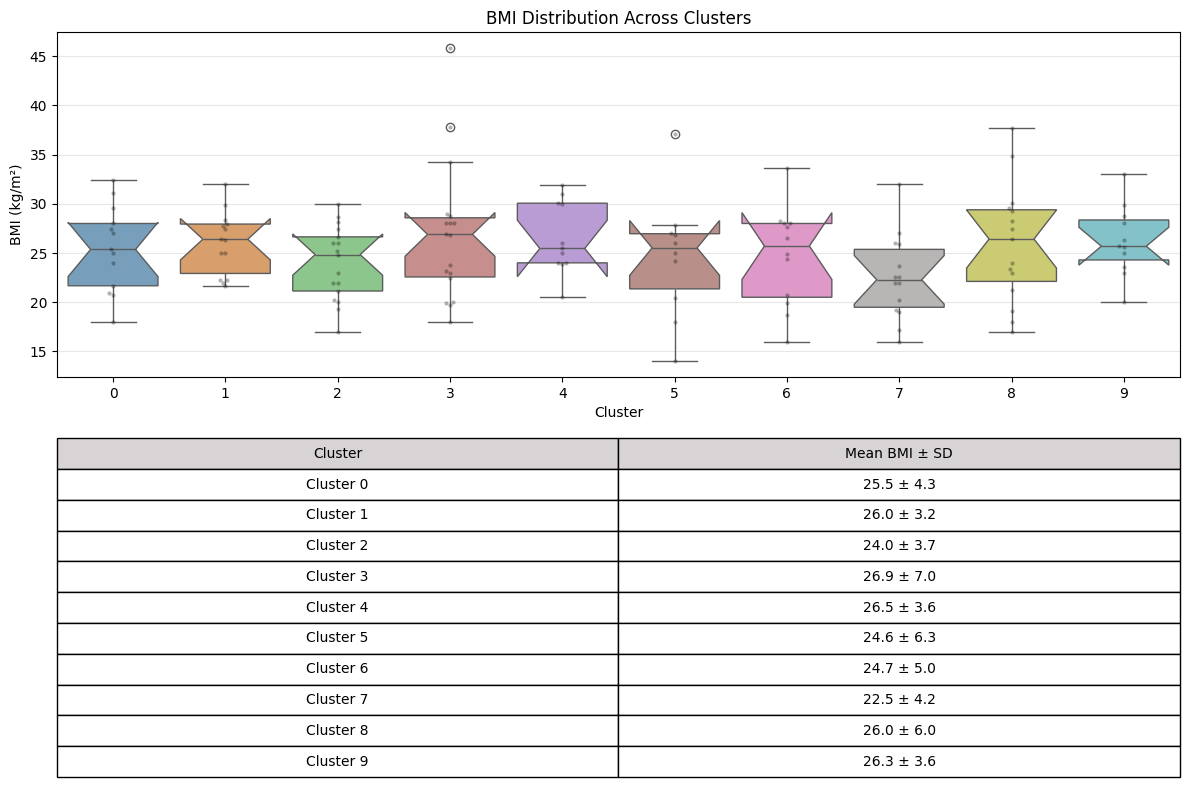


ANOVA test for BMI differences between clusters:
F-statistic: 1.055
P-value: 0.4010
No significant differences in BMI between clusters


In [ ]:
# BMI visualization
bmi_data = original_clinical.copy()
bmi_data['Cluster'] = best_labels
n_clusters = bmi_data['Cluster'].nunique()
palette = [
    "#6ca1c6",  # blue
    "#ea9e5b",  # orange
    "#82d082",  # green
    "#d18484",  # red
    "#b993dd",  # purple
    "#c08b81",  # brown
    "#e98ece",  # pink
    "#b9b4b4",  # gray
    "#d9d966",  # yellow-green
    "#78cbd4"   # cyan
]

plt.figure(figsize=(12, 8))
ax1 = plt.subplot(2, 1, 1)
sns.boxplot(
    data=bmi_data,
    x='Cluster',
    y='bmi',
    palette=palette,
    hue='Cluster',
    dodge=False,
    legend=False,
    ax=ax1,
    notch=True
)
ax1.set_xlabel('Cluster')
ax1.set_ylabel('BMI (kg/m²)')
ax1.set_title('BMI Distribution Across Clusters')
ax1.grid(True, alpha=0.3, axis='y')
new_palette = sns.color_palette("Set2", len(bmi_data['Cluster'].unique()))
sns.swarmplot(
    data=bmi_data,
    x='Cluster',
    y='bmi',
    color='black',
    alpha=0.3,
    size=3,
    ax=ax1
)

cluster_stats = bmi_data.groupby('Cluster')['bmi'].agg(['mean', 'std', 'count']).round(2)
cluster_stats['mean_std'] = cluster_stats['mean'].astype(str) + ' ± ' + cluster_stats['std'].astype(str)

ax2 = plt.subplot(2, 1, 2)
ax2.axis('tight')
ax2.axis('off')
table_data = []
for cluster in sorted(bmi_data['Cluster'].unique()):
    cluster_subset = bmi_data[bmi_data['Cluster'] == cluster]
    mean_bmi = cluster_subset['bmi'].mean()
    std_bmi = cluster_subset['bmi'].std()
    table_data.append([f'Cluster {cluster}', f'{mean_bmi:.1f} ± {std_bmi:.1f}'])

table = ax2.table(
    cellText=table_data,
    colLabels=['Cluster', 'Mean BMI ± SD'],
    cellLoc='center',
    loc='center',
    colColours=["#D8D4D6"] * 3
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
plt.tight_layout()
plt.show()

# ANOVA test
if len(bmi_data['Cluster'].unique()) > 2:
    clusters = [bmi_data[bmi_data['Cluster'] == c]['bmi'].dropna() for c in sorted(bmi_data['Cluster'].unique())]
    f_stat, p_value = stats.f_oneway(*clusters)
    print(f"\nANOVA test for BMI differences between clusters:")
    print(f"F-statistic: {f_stat:.3f}")
    print(f"P-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("Significant differences in BMI between clusters (p < 0.05)")
    else:
        print("No significant differences in BMI between clusters")

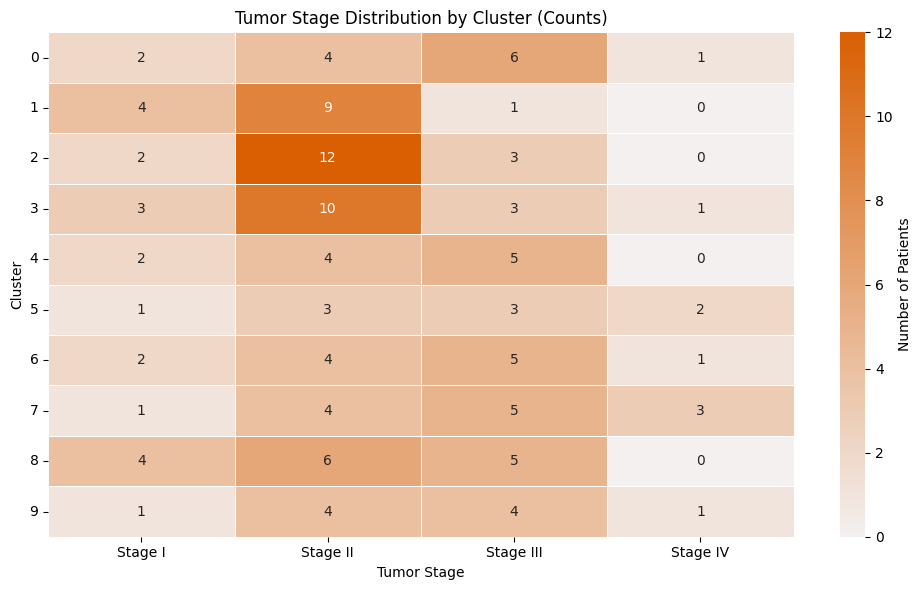

In [153]:
# --- Tumor stage distribution ---
stage_mapping = {1: 'Stage I', 2: 'Stage II', 3: 'Stage III', 4: 'Stage IV'}

temp_data = cluster_clinical.copy()
temp_data['tumor_stage_label'] = temp_data['tumor_stage_num'].map(stage_mapping)

stage_counts = pd.crosstab(
    temp_data['Cluster'],
    temp_data['tumor_stage_label'].fillna('Unknown')
)
stage_order = ['Stage I', 'Stage II', 'Stage III', 'Stage IV']
stage_counts = stage_counts.reindex(columns=stage_order, fill_value=0)

fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(
    stage_counts,
    annot=True,
    fmt='d',
    cmap = sns.light_palette("#d95f02", as_cmap=True),
    ax=ax,
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Number of Patients'}
)
ax.set_xlabel('Tumor Stage')
ax.set_ylabel('Cluster')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
ax.set_title('Tumor Stage Distribution by Cluster (Counts)')
plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

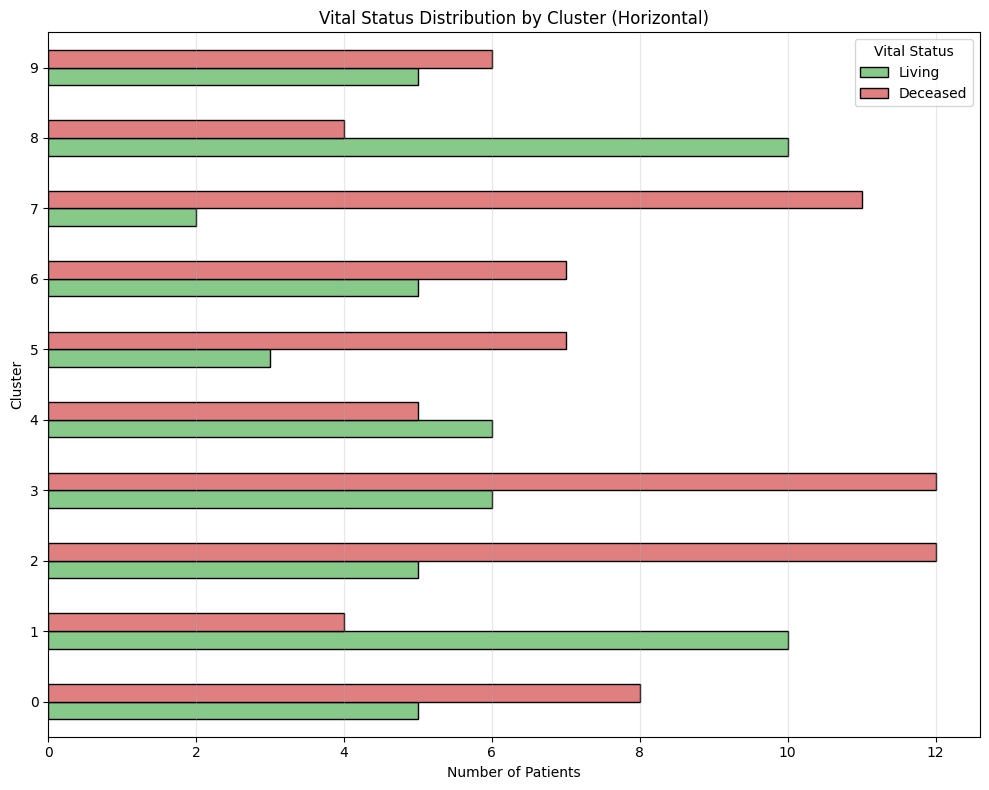

In [157]:
# --- Vital Status distribution barplot by cluster ---
plt.figure(figsize=(10, 8))
vital_counts = pd.crosstab(cluster_clinical['Cluster'], cluster_clinical['vital_status'])
vital_counts = vital_counts.rename(columns={0: 'Living', 1: 'Deceased'})
vital_counts = vital_counts.sort_index()
ax = vital_counts.plot(
    kind='barh',  
    stacked=False,
    color={'Living': "#86C988", 'Deceased': "#DF7F7F"},
    edgecolor='black',
    figsize=(10, 8)
)
plt.yticks(rotation=0)  
plt.legend(title="Vital Status")
plt.ylabel('Cluster')  
plt.xlabel('Number of Patients') 
plt.title('Vital Status Distribution by Cluster (Horizontal)')
plt.grid(axis='x', alpha=0.3)  
plt.tight_layout()
plt.show()

# Data prediction

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (accuracy_score, f1_score, balanced_accuracy_score, 
                              confusion_matrix, classification_report)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [32]:
# Extract tumor stage labels
stage_labels = clinical_aligned['tumor_stage_num'].copy()

# Analysis of label distribution
print("\nOriginal label distribution:")
print(stage_labels.value_counts().sort_index())
print(f"\nMissing values: {stage_labels.isna().sum()} ({stage_labels.isna().sum()/len(stage_labels)*100:.1f}%)")

# Use features that are likely correlated with tumor stage
imputation_features = [
    'age_at_initial_pathologic_diagnosis',
    'bmi',
    'sex',
    'pn_num',  # pathologic lymph nodes
    'pt_num',  # pathologic tumor
    'pm_num',  # pathologic metastasis
    'residual_num',
    'alcohol_num',
    'tobacco_num',
    'vital_status',
    'tumor_necrosis',
    'lymph_vascular_invasion',
    'perineural_invasion'
]

available_features = [f for f in imputation_features if f in clinical_aligned.columns]

clinical_for_imputation = clinical_aligned[available_features].copy()
clinical_for_imputation['tumor_stage_num'] = stage_labels

# Identify which patients have missing tumor stage
missing_mask = stage_labels.isna()
missing_indices = np.where(missing_mask)[0]
print(f"\nPatients with missing tumor stage: {missing_mask.sum()}")
for idx in missing_indices:
    patient_id = common_patients[idx]
    print(f"  - {patient_id}")


Original label distribution:
tumor_stage_num
1.0    22
2.0    60
3.0    40
4.0     9
Name: count, dtype: int64

Missing values: 6 (4.4%)

Patients with missing tumor stage: 6
  - C3L-02701
  - C3L-03635
  - C3N-00709
  - C3N-01715
  - C3N-01719
  - C3N-03039


In [33]:
# First, impute the clinical features themselves (they may have NaNs)
print(f"\nPre-processing: Imputing missing values in clinical features...")
clinical_features_only = clinical_for_imputation[available_features].copy()
features_imputer = KNNImputer(n_neighbors=5, weights='distance')
clinical_features_imputed = pd.DataFrame(
    features_imputer.fit_transform(clinical_features_only),
    columns=available_features,
    index=clinical_features_only.index
)
print(f"✓ Clinical features imputed")

# Now add tumor_stage_num back for stage imputation
clinical_for_stage_imputation = clinical_features_imputed.copy()
clinical_for_stage_imputation['tumor_stage_num'] = stage_labels

# KNN Imputation for tumor stage
print(f"\nPerforming KNN imputation for tumor stage (k=5 neighbors, distance-weighted)...")
knn_imputer = KNNImputer(n_neighbors=5, weights='distance')
clinical_fully_imputed = pd.DataFrame(
    knn_imputer.fit_transform(clinical_for_stage_imputation),
    columns=clinical_for_stage_imputation.columns,
    index=clinical_for_stage_imputation.index
)

# Extract imputed tumor stages and round to nearest integer
stage_labels_imputed = clinical_fully_imputed['tumor_stage_num'].round().astype(int)
stage_labels_imputed = stage_labels_imputed.clip(1, 4)

# Show imputed values with neighbor information
print(f"\n✓ Imputed values:")
for idx in missing_indices:
    patient_id = common_patients[idx]
    imputed_stage = int(stage_labels_imputed.iloc[idx])
    print(f"  Patient {patient_id}: Stage {imputed_stage}")
    
    # Show the nearest neighbors used for imputation (using imputed features)
    patient_features = clinical_features_imputed.iloc[idx].values.reshape(1, -1)
    
    # Find distances to all other patients
    distances = pairwise_distances(
        patient_features, 
        clinical_features_imputed.values,
        metric='euclidean'
    )[0]
    
    # Get indices of 5 nearest neighbors (excluding self)
    nearest_indices = np.argsort(distances)[1:6]
    neighbor_stages = stage_labels.iloc[nearest_indices].dropna()
    
    if len(neighbor_stages) > 0:
        neighbor_stages_list = [int(s) for s in neighbor_stages.values]
        print(f"    → Based on neighbors with stages: {neighbor_stages_list}")
        print(f"    → Mean of neighbors: {np.mean(neighbor_stages_list):.2f}")


Pre-processing: Imputing missing values in clinical features...
✓ Clinical features imputed

Performing KNN imputation for tumor stage (k=5 neighbors, distance-weighted)...

✓ Imputed values:
  Patient C3L-02701: Stage 2
    → Based on neighbors with stages: [2, 2, 2, 2, 1]
    → Mean of neighbors: 1.80
  Patient C3L-03635: Stage 2
    → Based on neighbors with stages: [2, 1, 2, 1, 2]
    → Mean of neighbors: 1.60
  Patient C3N-00709: Stage 2
    → Based on neighbors with stages: [2, 2, 2, 1, 2]
    → Mean of neighbors: 1.80
  Patient C3N-01715: Stage 3
    → Based on neighbors with stages: [3, 2, 4, 2, 2]
    → Mean of neighbors: 2.60
  Patient C3N-01719: Stage 2
    → Based on neighbors with stages: [3, 3, 2, 2, 2]
    → Mean of neighbors: 2.40
  Patient C3N-03039: Stage 2
    → Based on neighbors with stages: [2, 2, 2, 2, 3]
    → Mean of neighbors: 2.20


In [34]:
stage_labels_clean = stage_labels_imputed.copy()

print(f"\n✓ Final label distribution after KNN imputation:")
print(f"  - Total patients: {len(stage_labels_clean)}")
for stage, count in stage_labels_clean.value_counts().sort_index().items():
    pct = count / len(stage_labels_clean) * 100
    print(f"    Stage {int(stage)}: {count} patients ({pct:.1f}%)")


✓ Final label distribution after KNN imputation:
  - Total patients: 137
    Stage 1: 22 patients (16.1%)
    Stage 2: 65 patients (47.4%)
    Stage 3: 41 patients (29.9%)
    Stage 4: 9 patients (6.6%)


In [35]:
# Check class balance
stage_counts = stage_labels_clean.value_counts()
min_class_size = stage_counts.min()
max_class_size = stage_counts.max()
imbalance_ratio = max_class_size / min_class_size
print(f"\n  - Class imbalance ratio: {imbalance_ratio:.2f}:1")
if imbalance_ratio > 3:
    print("      Warning: Significant class imbalance detected")


  - Class imbalance ratio: 7.22:1


In [36]:
fused_similarity_clean = fused_similarity.copy()
fused_affinity_clean = fused_affinity.copy()
spectral_embedding_clean = spectral_embedding.copy()
common_patients_clean = common_patients.copy()

# 2. Train/Test split

# Stratified split to maintain class distribution
train_idx, test_idx = train_test_split(
    np.arange(len(stage_labels_clean)),
    test_size=0.25,
    random_state=42,
    stratify=stage_labels_clean
)

y_train = stage_labels_clean.iloc[train_idx].values
y_test = stage_labels_clean.iloc[test_idx].values

print(f"Training set: {len(train_idx)} patients")
print(f"Test set: {len(test_idx)} patients")
print(f"\nTraining set distribution:")
train_dist = pd.Series(y_train).value_counts().sort_index()
for stage, count in train_dist.items():
    pct = count / len(y_train) * 100
    print(f"  Stage {int(stage)}: {count} ({pct:.1f}%)")

print(f"\nTest set distribution:")
test_dist = pd.Series(y_test).value_counts().sort_index()
for stage, count in test_dist.items():
    pct = count / len(y_test) * 100
    print(f"  Stage {int(stage)}: {count} ({pct:.1f}%)")

Training set: 102 patients
Test set: 35 patients

Training set distribution:
  Stage 1: 16 (15.7%)
  Stage 2: 48 (47.1%)
  Stage 3: 31 (30.4%)
  Stage 4: 7 (6.9%)

Test set distribution:
  Stage 1: 6 (17.1%)
  Stage 2: 17 (48.6%)
  Stage 3: 10 (28.6%)
  Stage 4: 2 (5.7%)


In [37]:
print("=== DATA PREDICTION ===")
print("\nMethod 1: K-NEAREST NEIGHBORS")
# Convert similarity to distance for KNN
similarity_train = fused_similarity_clean[train_idx][:, train_idx]
similarity_test_train = fused_similarity_clean[test_idx][:, train_idx]

# Find optimal K using cross-validation on training set
k_values = range(3, 21, 2)
cv_scores = []

print("\nOptimizing K parameter using 5-fold cross-validation...")
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='precomputed')
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_scores = []
    for fold_train_idx, fold_val_idx in skf.split(similarity_train, y_train):
        # Build distance matrix for this fold
        fold_sim_train = similarity_train[fold_train_idx][:, fold_train_idx]
        fold_sim_val = similarity_train[fold_val_idx][:, fold_train_idx]
        fold_dist_train = 1 - fold_sim_train
        fold_dist_val = 1 - fold_sim_val
        
        knn_fold = KNeighborsClassifier(n_neighbors=k, metric='precomputed')
        knn_fold.fit(fold_dist_train, y_train[fold_train_idx])
        y_pred = knn_fold.predict(fold_dist_val)
        fold_scores.append(balanced_accuracy_score(y_train[fold_val_idx], y_pred))
    
    mean_score = np.mean(fold_scores)
    cv_scores.append(mean_score)
    print(f"  K={k}: Balanced Accuracy = {mean_score:.3f}")

=== DATA PREDICTION ===

Method 1: K-NEAREST NEIGHBORS

Optimizing K parameter using 5-fold cross-validation...
  K=3: Balanced Accuracy = 0.238
  K=5: Balanced Accuracy = 0.263
  K=7: Balanced Accuracy = 0.275
  K=9: Balanced Accuracy = 0.269
  K=11: Balanced Accuracy = 0.274
  K=13: Balanced Accuracy = 0.269
  K=15: Balanced Accuracy = 0.280
  K=17: Balanced Accuracy = 0.287
  K=19: Balanced Accuracy = 0.285


In [38]:
optimal_k = k_values[np.argmax(cv_scores)]
print(f"\n✓ Optimal K: {optimal_k} (Balanced Accuracy: {max(cv_scores):.3f})")

# Train final KNN model with optimal K
distance_train = 1 - similarity_train
distance_test_train = 1 - similarity_test_train

knn_model = KNeighborsClassifier(n_neighbors=optimal_k, metric='precomputed')
knn_model.fit(distance_train, y_train)
y_pred_knn = knn_model.predict(distance_test_train)

# Evaluate
acc_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')
bacc_knn = balanced_accuracy_score(y_test, y_pred_knn)

print(f"\n KNN Results (K={optimal_k}):")
print(f"  - Accuracy: {acc_knn:.3f}")
print(f"  - Balanced Accuracy: {bacc_knn:.3f}")
print(f"  - F1-Score (weighted): {f1_knn:.3f}")


✓ Optimal K: 17 (Balanced Accuracy: 0.287)

 KNN Results (K=17):
  - Accuracy: 0.429
  - Balanced Accuracy: 0.221
  - F1-Score (weighted): 0.310


In [ ]:
print("\nMETHOD 2: STANDARD ML MODELS")
X_train = spectral_embedding_clean[train_idx]
X_test = spectral_embedding_clean[test_idx]

# Standardize features
scaler_ml = StandardScaler()
X_train_scaled = scaler_ml.fit_transform(X_train)
X_test_scaled = scaler_ml.transform(X_test)

models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,  
        random_state=42,
        class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200, 
        random_state=42, 
        class_weight='balanced',
        max_depth=10
    )
}

ml_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    bacc = balanced_accuracy_score(y_test, y_pred)
    
    ml_results[name] = {
        'model': model,
        'predictions': y_pred,
        'accuracy': acc,
        'f1_score': f1,
        'balanced_accuracy': bacc
    }
    
    print(f"  - Accuracy: {acc:.3f}")
    print(f"  - Balanced Accuracy: {bacc:.3f}")
    print(f"  - F1-Score (weighted): {f1:.3f}")


METHOD 2: STANDARD ML MODELS

Training Logistic Regression...
  - Accuracy: 0.314
  - Balanced Accuracy: 0.236
  - F1-Score (weighted): 0.357

Training Random Forest...
  - Accuracy: 0.486
  - Balanced Accuracy: 0.325
  - F1-Score (weighted): 0.454


In [40]:
# Comparing methods
comparison_df = pd.DataFrame({
    'Method': [
        f'KNN (K={optimal_k})',
        'Logistic Regression',
        'Random Forest'
    ],
    'Accuracy': [
        acc_knn,
        ml_results['Logistic Regression']['accuracy'],
        ml_results['Random Forest']['accuracy']
    ],
    'Balanced Accuracy': [
        bacc_knn,
        ml_results['Logistic Regression']['balanced_accuracy'],
        ml_results['Random Forest']['balanced_accuracy']
    ],
    'F1-Score': [
        f1_knn,
        ml_results['Logistic Regression']['f1_score'],
        ml_results['Random Forest']['f1_score']
    ]
})

print("\n" + tabulate(comparison_df, headers='keys', tablefmt='github', 
                      floatfmt='.3f', showindex=False))

# Find best method
best_method_idx = comparison_df['Balanced Accuracy'].idxmax()
best_method_name = comparison_df.loc[best_method_idx, 'Method']
best_bacc = comparison_df.loc[best_method_idx, 'Balanced Accuracy']

print(f"\n🏆 BEST METHOD: {best_method_name} (Balanced Accuracy: {best_bacc:.3f})")


| Method              |   Accuracy |   Balanced Accuracy |   F1-Score |
|---------------------|------------|---------------------|------------|
| KNN (K=17)          |      0.429 |               0.221 |      0.310 |
| Logistic Regression |      0.314 |               0.236 |      0.357 |
| Random Forest       |      0.486 |               0.325 |      0.454 |

🏆 BEST METHOD: Random Forest (Balanced Accuracy: 0.325)


In [41]:
# Determine which predictions to use for detailed analysis
if best_method_idx == 0:
    best_predictions = y_pred_knn
else:
    model_name = comparison_df.loc[best_method_idx, 'Method']
    best_predictions = ml_results[model_name]['predictions']

# Classification Report
unique_stages = sorted(stage_labels_clean.unique())
stage_names = [f'Stage {int(s)}' for s in unique_stages]

print(f"\nClassification Report ({best_method_name}):")
print(classification_report(y_test, best_predictions, 
                          target_names=stage_names,
                          zero_division=0))


Classification Report (Random Forest):
              precision    recall  f1-score   support

     Stage 1       1.00      0.33      0.50         6
     Stage 2       0.54      0.76      0.63        17
     Stage 3       0.22      0.20      0.21        10
     Stage 4       0.00      0.00      0.00         2

    accuracy                           0.49        35
   macro avg       0.44      0.32      0.34        35
weighted avg       0.50      0.49      0.45        35



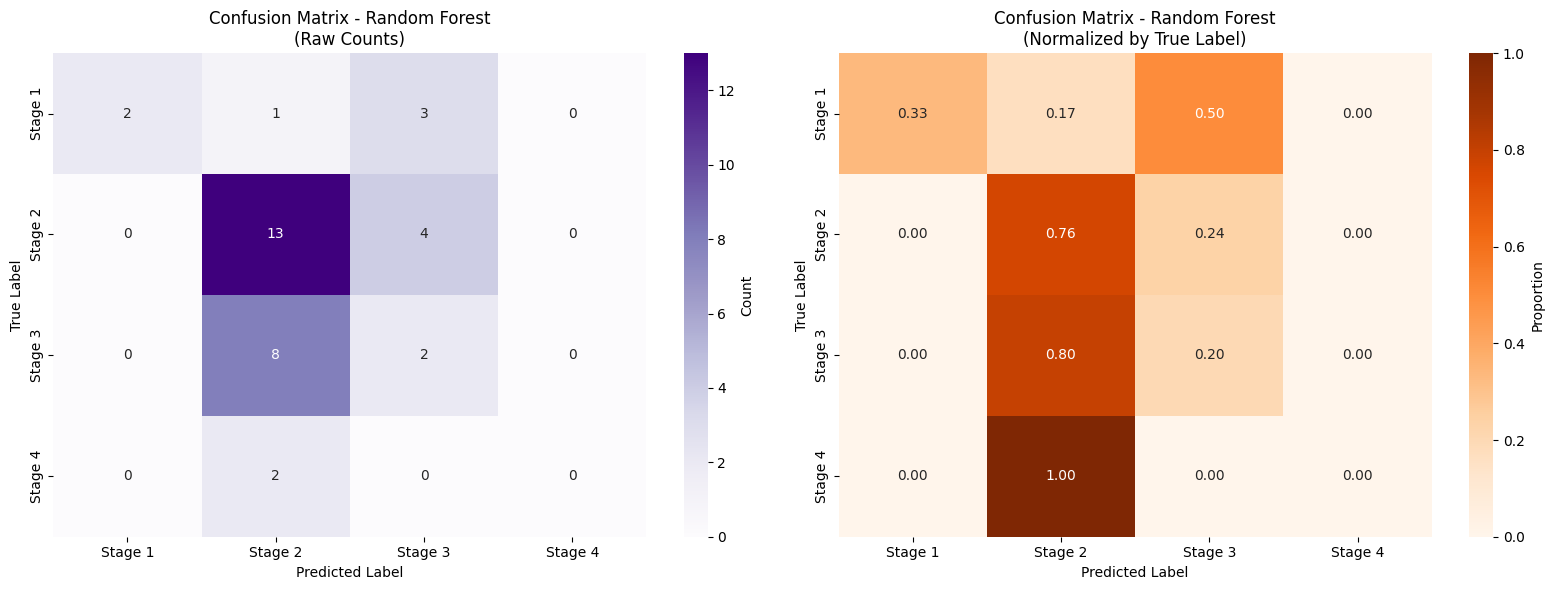

In [166]:
# Confusion Matrix
cm = confusion_matrix(y_test, best_predictions)
stage_names = [f'Stage {int(s)}' for s in sorted(stage_labels_clean.unique())]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=stage_names, yticklabels=stage_names,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title(f'Confusion Matrix - {best_method_name}\n(Raw Counts)')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Normalized by row (recall)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Oranges',
            xticklabels=stage_names, yticklabels=stage_names,
            ax=axes[1], cbar_kws={'label': 'Proportion'}, vmin=0, vmax=1)
axes[1].set_title(f'Confusion Matrix - {best_method_name}\n(Normalized by True Label)')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

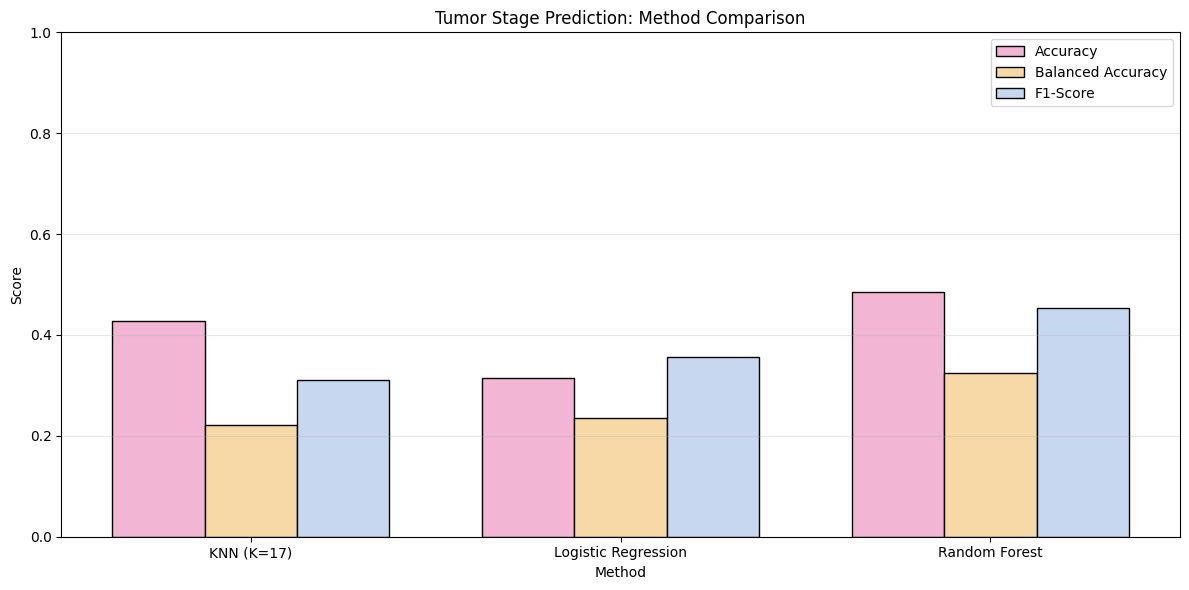

In [183]:
# Performance comparison visualization
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison_df))
width = 0.25
bars1 = ax.bar(x - width, comparison_df['Accuracy'], width, 
               label='Accuracy', color="#f2b5d4", edgecolor='black')
bars2 = ax.bar(x, comparison_df['Balanced Accuracy'], width,
               label='Balanced Accuracy', color="#f7d9a8", edgecolor='black')
bars3 = ax.bar(x + width, comparison_df['F1-Score'], width,
               label='F1-Score', color="#c8d7f0", edgecolor='black')
ax.set_xlabel('Method')
ax.set_ylabel('Score')
ax.set_title('Tumor Stage Prediction: Method Comparison')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Method'])
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.0])
plt.tight_layout()
plt.show()

In [44]:
# Omics contribution analysis

# Analyze which omics layers contribute most to correct predictions
# by comparing similarity between correctly and incorrectly predicted samples
correct_mask = (best_predictions == y_test)
print(f"\nCorrectly predicted: {correct_mask.sum()} / {len(y_test)} ({correct_mask.sum()/len(y_test)*100:.1f}%)")
omics_contributions = {}
for omics_name in similarity_matrices.keys():
    omics_sim = similarity_matrices[omics_name]
    omics_sim_test = omics_sim[test_idx][:, test_idx]
    
    # Mean similarity within correctly predicted samples
    if correct_mask.sum() > 1:
        correct_idx = np.where(correct_mask)[0]
        correct_similarities = []
        for i in range(len(correct_idx)):
            for j in range(i+1, len(correct_idx)):
                correct_similarities.append(omics_sim_test[correct_idx[i], correct_idx[j]])
        mean_correct_sim = np.mean(correct_similarities) if correct_similarities else 0
    else:
        mean_correct_sim = 0
    
    # Mean similarity within incorrectly predicted samples
    if (~correct_mask).sum() > 1:
        incorrect_idx = np.where(~correct_mask)[0]
        incorrect_similarities = []
        for i in range(len(incorrect_idx)):
            for j in range(i+1, len(incorrect_idx)):
                incorrect_similarities.append(omics_sim_test[incorrect_idx[i], incorrect_idx[j]])
        mean_incorrect_sim = np.mean(incorrect_similarities) if incorrect_similarities else 0
    else:
        mean_incorrect_sim = 0
    
    # Contribution score: higher similarity in correct predictions indicates better contribution
    contribution_score = mean_correct_sim - mean_incorrect_sim
    
    omics_contributions[omics_name] = {
        'mean_correct_sim': mean_correct_sim,
        'mean_incorrect_sim': mean_incorrect_sim,
        'contribution_score': contribution_score
    }
    
    print(f"\n{omics_name}:")
    print(f"  - Mean similarity (correct predictions): {mean_correct_sim:.3f}")
    print(f"  - Mean similarity (incorrect predictions): {mean_incorrect_sim:.3f}")
    print(f"  - Contribution score: {contribution_score:.3f}")


Correctly predicted: 17 / 35 (48.6%)

circRNA:
  - Mean similarity (correct predictions): 0.089
  - Mean similarity (incorrect predictions): 0.081
  - Contribution score: 0.008

miRNA:
  - Mean similarity (correct predictions): 0.112
  - Mean similarity (incorrect predictions): 0.075
  - Contribution score: 0.037

mRNA:
  - Mean similarity (correct predictions): 0.121
  - Mean similarity (incorrect predictions): 0.094
  - Contribution score: 0.028

phosphoproteome:
  - Mean similarity (correct predictions): 0.128
  - Mean similarity (incorrect predictions): 0.103
  - Contribution score: 0.026

proteome:
  - Mean similarity (correct predictions): 0.094
  - Mean similarity (incorrect predictions): 0.116
  - Contribution score: -0.023

SCNA:
  - Mean similarity (correct predictions): 0.108
  - Mean similarity (incorrect predictions): 0.110
  - Contribution score: -0.001


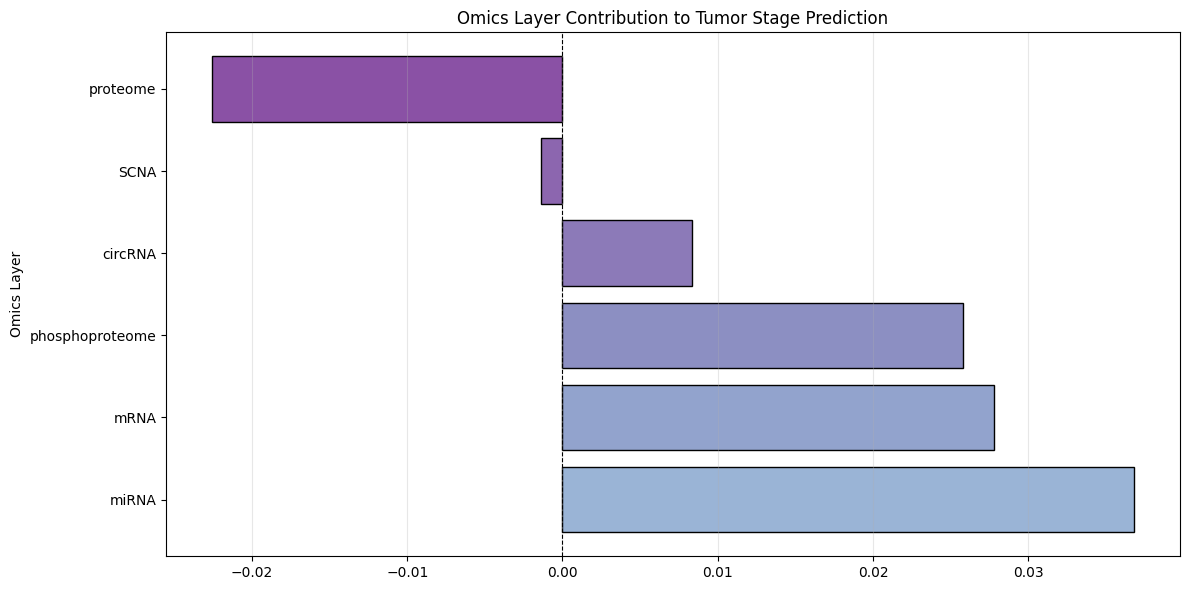


✓ Omics layers ranked by contribution:
  miRNA: 0.037
  mRNA: 0.028
  phosphoproteome: 0.026
  circRNA: 0.008
  SCNA: -0.001
  proteome: -0.023


In [197]:
# Visualize omics contributions
contrib_df = pd.DataFrame({
    'Omics': list(omics_contributions.keys()),
    'Contribution Score': [omics_contributions[k]['contribution_score'] for k in omics_contributions.keys()]
}).sort_values('Contribution Score', ascending=False)

plt.figure(figsize=(12, 6))
colors_omics = plt.cm.BuPu(np.linspace(0.4, 0.7, len(contrib_df)))
bars = plt.barh(contrib_df['Omics'], contrib_df['Contribution Score'], 
                color=colors_omics, edgecolor='black')
plt.ylabel('Omics Layer')
plt.title('Omics Layer Contribution to Tumor Stage Prediction')
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Rank omics by contribution
print("\n✓ Omics layers ranked by contribution:")
for idx, row in contrib_df.iterrows():
    print(f"  {row['Omics']}: {row['Contribution Score']:.3f}")